# <span style='font-family:"Times New Roman"'> <span styel=''> **DATA CLEAN UP**

<span style='font-family:"Times New Roman"'> <span styel=''> *Emile Cohen* 
    
*March 2020*

**Goal:** In this notebook, we assess the right purity threshold to cut the uncertain samples while keeping enough samples for our study. We also look at the effects of changing the purity threshold on the subgroups definition.



**NB1:** In each part, you must run the cells from the begining in order to initialize the variables

**NB2:** All functions used for the plots are located in utils/custom_tools.py

---

In [1]:
%run -i '../../utils/setup_environment.ipy'
from utils.analysis_tools import *

import warnings, math

warnings.filterwarnings('ignore')
import ptitprince as pt
import IPython.display
from itertools import cycle, islice
from lifelines import KaplanMeierFitter

data_path = '../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

---

In [2]:
master = pd.read_pickle(data_path + 'merged_data/master_file.pkl')
master

,Sample_Id,Tumor_Id,Patient_Id,Cancer_Type,Cancer_Type_Detailed,Sample_Type,purity,ploidy,samples_per_patient,Overall Survival Status,Overall Survival (Months),MSI Score,TMB_Score,Patient_Current_Age,Sex,Ethnicity_Category,Race_Category,mutationStatus,Somatic_Status,tp53_key_1,tp53_vc_1,tp53_ccf_1,tp53_vaf_1,tp53_HGVSp_1,tp53_spot_1,tp53_key_2,tp53_vc_2,tp53_ccf_2,tp53_vaf_2,tp53_HGVSp_2,tp53_spot_2,tp53_key_3,tp53_vc_3,tp53_ccf_3,tp53_vaf_3,tp53_HGVSp_3,tp53_spot_3,tp53_key_4,tp53_vc_4,tp53_ccf_4,tp53_vaf_4,tp53_HGVSp_4,tp53_spot_4,tp53_key_5,tp53_vc_5,tp53_ccf_5,tp53_vaf_5,tp53_HGVSp_5,tp53_spot_5,tp53_count,tp53_tcn,tp53_mcn,tp53_lcn,tp53_seg_length,tp53_cn_state,tp53_cf,wgd,mutation_count,gene_count,driver_count,max_vaf,tp53_exp_nb_1,tp53_exp_nb_2,tp53_exp_nb_3,tp53_exp_nb_4,tp53_exp_nb_5,tp53_residual_1,tp53_residual_2,tp53_residual_3,tp53_residual_4,tp53_residual_5,tp53_first_group,tp53_group,tp53_res_group,chr_affected,chr_loss,chr_gain,chr_cnloh,frac_genome_altered,tp53_vc_group_1,tp53_vc_group_2,tp53_vc_group_3,tp53_vc_group_4,tp53_vc_group_5
0,P-0034223-T01-IM6_P-0034223-N01-IM6,P-0034223-T01-IM6,P-0034223,Breast Cancer,Invasive Breast Carcinoma,Metastasis,0.941111,2.241830,1.0,LIVING,NaN,0.55,5.3,63.0,Female,NaN,NO VALUE ENTERED,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2.0,1.0,1.0,80668592.0,DIPLOID,1.000000,-1.0,6,6.0,0,0.901899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WILD_TYPE,None,None,3,2,2,0,0.08,None,None,None,None,None
1,P-0009819-T01-IM5_P-0009819-N01-IM5,P-0009819-T01-IM5,P-0009819,Prostate Cancer,Prostate Adenocarcinoma,Primary,0.275237,2.681075,1.0,LIVING,23.441,0.00,1.0,72.0,Male,Non-Spanish; Non-Hispanic,NO VALUE ENTERED,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2.0,1.0,1.0,80668300.0,DIPLOID,1.000000,-1.0,1,1.0,0,0.148014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WILD_TYPE,None,None,4,4,0,0,0.137,None,None,None,None,None
2,P-0025956-T01-IM6_P-0025956-N01-IM6,P-0025956-T01-IM6,P-0025956,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,Primary,0.185874,3.496971,1.0,DECEASED,3.584,0.00,5.3,71.0,Female,Non-Spanish; Non-Hispanic,WHITE,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,3.0,2.0,1.0,80668431.0,LOSS AFTER,0.169170,1.0,6,6.0,0,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WILD_TYPE,None,None,13,13,1,1,0.624,None,None,None,None,None
3,P-0027408-T01-IM6_P-0027408-N01-IM6,P-0027408-T01-IM6,P-0027408,Non-Small Cell Lung Cancer,Non-Small Cell Lung Cancer,Metastasis,0.308886,1.811066,1.0,LIVING,22.586,0.27,17.6,67.0,Female,Non-Spanish; Non-Hispanic,WHITE,SOMATIC,Matched,P-0027408-T01-IM617_7578409_CT_TC,Missense_Mutation,0.925,0.168901,p.Arg174Glu,174,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,1,1.0,1.0,0.0,26256025.0,HETLOSS,0.275073,-1.0,20,18.0,0,0.192475,0.924711,NaN,NaN,NaN,NaN,0.075289,NaN,NaN,NaN,NaN,LOSS,>=1_LOSS,no_tp53_res,12,11,3,0,0.444,missense,None,None,None,None
4,P-0006554-T01-IM5_P-0006554-N01-IM5,P-0006554-T01-IM5,P-0006554,Glioma,Anaplastic Oligodendroglioma,Primary,0.715208,1.910719,1.0,LIVING,26.170,1.30,46.2,55.0,Female,Non-Spanish; Non-Hispanic,WHITE,SOMATIC,Matched,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,None,None,NaN,NaN,None,None,0,2.0,1.0,1.0,40254480.0,DIPLOID,1.000000,-1.0,47,39.0,0,0.706897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WILD_TYPE,None,None,5,4,1,0,0.173,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

# Function definitions

In [3]:
sns.set_style("whitegrid", {'grid.color': '0.98'})
my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))


def annotate_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=True, labelleft=True)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)


def def_fig_set(figsize=(15, 12), number=6):
    fig = plt.figure(figsize=figsize)
    if number == 6:
        ax1 = plt.subplot2grid(shape=(3, 7), loc=(0, 0), colspan=3)
        ax2 = plt.subplot2grid((3, 7), (0, 4), colspan=3)
        ax3 = plt.subplot2grid((3, 7), (1, 0), colspan=3)
        ax4 = plt.subplot2grid((3, 7), (1, 4), colspan=3)
        ax5 = plt.subplot2grid((3, 7), (2, 0), colspan=3)
        ax6 = plt.subplot2grid((3, 7), (2, 4), colspan=3)

    if number == 5:
        ax1 = plt.subplot2grid(shape=(3, 7), loc=(0, 0), colspan=3)
        ax2 = plt.subplot2grid((3, 7), (0, 4), colspan=3)
        ax3 = plt.subplot2grid((3, 7), (1, 0), colspan=3)
        ax4 = plt.subplot2grid((3, 7), (1, 4), colspan=3)
        ax5 = plt.subplot2grid((3, 7), (2, 2), colspan=3)

    if number == 4:
        ax1 = plt.subplot2grid(shape=(3, 7), loc=(0, 0), colspan=3)
        ax2 = plt.subplot2grid((3, 7), (0, 4), colspan=3)
        ax3 = plt.subplot2grid((3, 7), (1, 0), colspan=3)
        ax4 = plt.subplot2grid((3, 7), (1, 4), colspan=3)
        
    annotate_axes(fig)

    return fig


def get_densities(master:pd.DataFrame, metrics:str, fig_title:str, xlabel, ylabel,  number=6, tp53_metrics=False, met_prim:str = None, clip = (0.0,3.0), x_lim =[0,1]):
    # We initialize the figure
    fig = def_fig_set(number = number)
    fig.tight_layout(pad=10, w_pad=0.5, h_pad=10)
    fig.suptitle(fig_title, fontsize=16, weight='bold')
    
    # We differentiate the groups if we have 
    if number==6: groups = ['>=1_LOSS', 'HOMDEL', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '0_HETLOSS']
    if number==5: groups = ['>=1_LOSS', 'HOMDEL', '1_WILD_TYPE', '>1muts', '>=1_cnLOH']
        
     # To have the numbers per group
    h = get_groupby(master, 'tp53_group', 'count')
    numbers = []
    for group in groups:
        numbers.append(int(h[h.index == group]['count']))
    cancer_number = [i + ' (' + str(j) + ')' for i, j in zip(groups, numbers)]
        
    for ax, group,i in zip(fig.axes, groups, range(len(groups))):
        data = master[master['tp53_group'] == group]
        
        if tp53_metrics == True:
            data_1 =  pd.DataFrame(data[['Tumor_Id', metrics + '_1']])
            data_1.columns = ['Tumor_Id', metrics]
            data_2 = pd.DataFrame(data[['Tumor_Id', metrics + '_2']])
            data_2.columns = ['Tumor_Id', metrics]
            data_3 = pd.DataFrame(data[['Tumor_Id', metrics + '_3']])
            data_3.columns = ['Tumor_Id', metrics]
            data_4 = pd.DataFrame(data[['Tumor_Id', metrics + '_4']])
            data_4.columns = ['Tumor_Id', metrics]
            data_5 = pd.DataFrame(data[['Tumor_Id', metrics + '_5']])
            data_5.columns = ['Tumor_Id', metrics]
            data_tot = data_1.append(data_2)
            data_tot = data_tot.append(data_3)
            data_tot = data_tot.append(data_4)
            data_tot = data_tot.append(data_5)
    
            data = pd.merge(left=data_tot, right=data[['Tumor_Id','tp53_cn_state', 'tp53_tcn', 'Sample_Type']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')
            print(group, len(data))

        
        
        if met_prim:
            data = data[data['Sample_Type'] == met_prim]
        sns.distplot(data[metrics], hist=False,kde_kws={'clip': clip, "shade": True}, ax=ax, color=my_colors[i])
        ax.set_xlim(x_lim)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Adding Mean and Median Information
        mean=round(data[metrics].mean(),2) ; median=round(data[metrics].median(),2)
        string = 'Mean: '+ str(mean) +'\nMedian: ' + str(median)
        ax.axvline(mean, color='g', linestyle='-', label='Mean: '+ str(mean))
        ax.axvline(median, color='b', linestyle='-', label='Median: ' + str(median))
        ax.legend()
        
        ax.set_title(cancer_number[i], weight = 'bold')

def compute_median_interval(x):
    median_list = []
    for group in [
            '>=1_cnLOH', '1_WILD_TYPE', '>1muts', 'HOMDEL', '>=1_LOSS',
            '0_HETLOSS'
    ]:
        median_list.append(master[master['tp53_group'] == group][
            master['purity'] > x.purity]['purity'].median())

    return [round(min(median_list), 2), round(max(median_list), 2)]

def compute_median_interval_custom(x):
    median_list = []
    for group in [
            '>=1_cnLOH', '>1muts', 'HOMDEL', '>=1_LOSS',
            '0_HETLOSS'
    ]:
        median_list.append(master[master['tp53_group'] == group][
            master['purity'] > x.purity]['purity'].median())
    median_list.append(master[master['tp53_group'] == '1_WILD_TYPE'][
            master['purity'] > x.range_custom]['purity'].median())
    return [round(min(median_list), 2), round(max(median_list), 2)]


def cut_master(master: pd.DataFrame, range_: list, threshold: float):
    '''
    This function returns the table of population quartiles for the parameters set and shows
    the purity andd ccf densities for the parameters.
    
    Arguments:
        - master: Dataframe
        - to_cut: column on which we want to cut. Example: 'purity'
        - threshold: betwwen 0 and 1 to cut the low range samples
    '''
    for group in [
            '>=1_cnLOH', '1_WILD_TYPE', '>1muts', 'HOMDEL', '>=1_LOSS',
            '0_HETLOSS'
    ]:
        a = pd.DataFrame(master[master['tp53_group'] == group])
        h = [len(a[a['purity'] <= x]) for x in range_]
        h_df = pd.DataFrame(h, columns=[group], index=range_)
        if group == '>=1_cnLOH':
            h_tot = h_df
        else:
            h_tot = pd.concat([h_tot, h_df], axis=1)

    h_tot['SUM'] = h_tot.apply(sum, axis=1)
    h_tot['ratio'] = h_tot.apply(
        lambda x: 100 * round(x.SUM / list(h_tot['SUM'])[-1], 3), axis=1)
    h_tot['purity'] = list(h_tot.index.values)
    h_tot['purity_median_interval'] = h_tot.apply(compute_median_interval,
                                                  axis=1)
    h_tot = h_tot.drop('purity', axis=1)

    master_cut = master[master['purity'] > threshold]
    get_densities(master_cut,
                  'purity',
                  fig_title='Purity',
                  xlabel='Purity',
                  ylabel='Density')
    get_densities(master_cut,
                  'tp53_ccf_1',
                  fig_title='CCF',
                  xlabel='ccf',
                  ylabel='Density',
                  number=5)
    return h_tot

def custom_cut_master(master: pd.DataFrame, range_uniform:list, range_custom:list, threshold:float):
    '''
    This function returns the table of population quartiles for the parameters set and shows
    the purity andd ccf densities for the parameters.
    '''
        
    for group in [
            '>=1_cnLOH', '>1muts', 'HOMDEL', '>=1_LOSS',
            '0_HETLOSS'
    ]:
        a = pd.DataFrame(master[master['tp53_group'] == group])
        h = [len(a[a['purity'] <= x]) for x in range_uniform]
        h_df = pd.DataFrame(h, columns=[group], index=range_uniform)
        if group == '>=1_cnLOH':
            h_tot = h_df
        else:
            h_tot = pd.concat([h_tot, h_df], axis=1)
    
    # custom cut-off for 1_WILD_TYPE
    a = pd.DataFrame(master[master['tp53_group'] == '1_WILD_TYPE'])
    h = [len(a[a['purity'] <= x]) for x in range_custom]
    h_df = pd.DataFrame(h, columns=['1_WILD_TYPE'], index=range_uniform)
    h_df['range_custom'] = range_custom
    h_tot = pd.concat([h_tot, h_df], axis=1)

    h_tot['SUM'] = h_tot[['>=1_cnLOH', '1_WILD_TYPE', '>1muts', 'HOMDEL', '>=1_LOSS','0_HETLOSS']].apply(sum, axis=1)
    h_tot['ratio'] = h_tot.apply(
        lambda x: 100 * round(x.SUM / list(h_tot['SUM'])[-1], 3), axis=1)
    h_tot['purity'] = list(h_tot.index.values)
    h_tot['purity_median_interval'] = h_tot.apply(compute_median_interval_custom,
                                                  axis=1)
    h_tot = h_tot.drop('purity', axis=1)

    return h_tot

def plot_copies_tcn(data, group, group_name, nb_muts):
    data = filter_muts(data, nb_muts)
    data_1 =  pd.DataFrame(data[['Tumor_Id','tp53_exp_nb_1']])
    data_1.columns = ['Tumor_Id', 'tp53_exp_nb']
    data_2 = pd.DataFrame(data[['Tumor_Id','tp53_exp_nb_2']])
    data_2.columns = ['Tumor_Id', 'tp53_exp_nb']
    data_3 = pd.DataFrame(data[['Tumor_Id','tp53_exp_nb_3']])
    data_3.columns = ['Tumor_Id', 'tp53_exp_nb']
    data_4 = pd.DataFrame(data[['Tumor_Id','tp53_exp_nb_4']])
    data_4.columns = ['Tumor_Id', 'tp53_exp_nb']
    data_5 = pd.DataFrame(data[['Tumor_Id','tp53_exp_nb_5']])
    data_5.columns = ['Tumor_Id', 'tp53_exp_nb']
    data_tot = data_1.append(data_2)
    data_tot = data_tot.append(data_3)
    data_tot = data_tot.append(data_4)
    data_tot = data_tot.append(data_5)
    
    data_tot = pd.merge(left=data_tot, right=data[['Tumor_Id','tp53_cn_state', 'tp53_tcn']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')

    dx="tp53_tcn"; dy="tp53_exp_nb"; ort="h"; pal = "muted"; sigma = .2; dhue = "cn_state"; dhue_order=group
    f, ax = plt.subplots(figsize=(15, 10))
    
    # Little trick for indeterminate group
    if group_name == 'INDETERMINATE':
        pt.RainCloud(x = dx, y = dy, data = data_tot, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort, alpha=.6, mv=.2)
    else:
        pt.RainCloud(x = dx, y = dy, data = data_tot, palette = pal, bw = sigma, hue=dhue, hue_order=dhue_order,
                 width_viol = .6, ax = ax, orient = ort, alpha=.6, mv=.2)
    ax.set_ylabel('Total Copy Number')
    ax.set_xlabel('Expected number of copies of Tp53 mutations')
    ax.set_title(group_name, weight = 'bold')
    
    return f, ax

# Purity Cut-Off Table

## Uniform cut-off

The following table allows us to know exactly the number of samples we lose in each subgroup for each purity threshold. Moreover, we can see the overall proportion of samples lost and the purity median intervals.

,>=1_cnLOH,1_WILD_TYPE,>1muts,HOMDEL,>=1_LOSS,0_HETLOSS,SUM,ratio,purity_median_interval
0.20,124,244,41,6,71,49,535,3.7,"[0.31, 0.52]"
0.21,172,301,56,9,130,72,740,5.1,"[0.32, 0.53]"
0.22,235,377,66,9,202,98,987,6.9,"[0.33, 0.53]"
0.23,297,446,77,15,259,131,1225,8.5,"[0.34, 0.54]"
0.24,388,509,89,19,310,171,1486,10.3,"[0.36, 0.54]"
0.25,470,560,100,23,404,217,1774,12.3,"[0.37, 0.54]"
0.26,552,608,111,25,496,258,2050,14.2,"[0.37, 0.54]"
0.27,646,662,136,32,570,308,2354,16.4,"[0.39, 0.55]"
0.28,736,714,156,39,644,351,2640,18.4,"[0.4, 0.56]"
0.30,1009,867,202,45,839,438,3400,23.6,"[0.45, 0.57]"


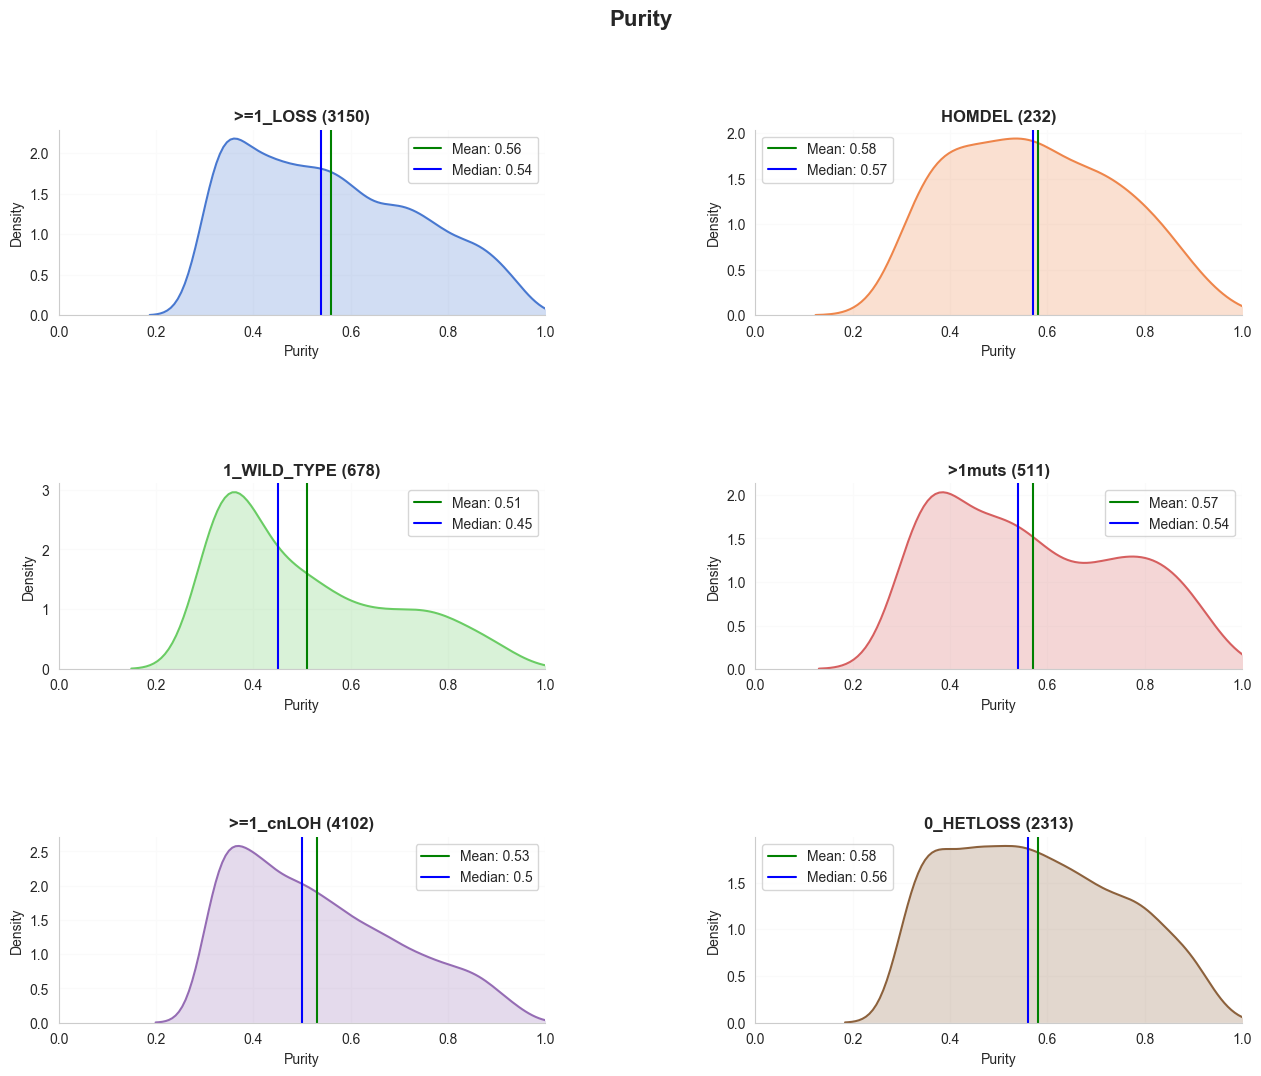

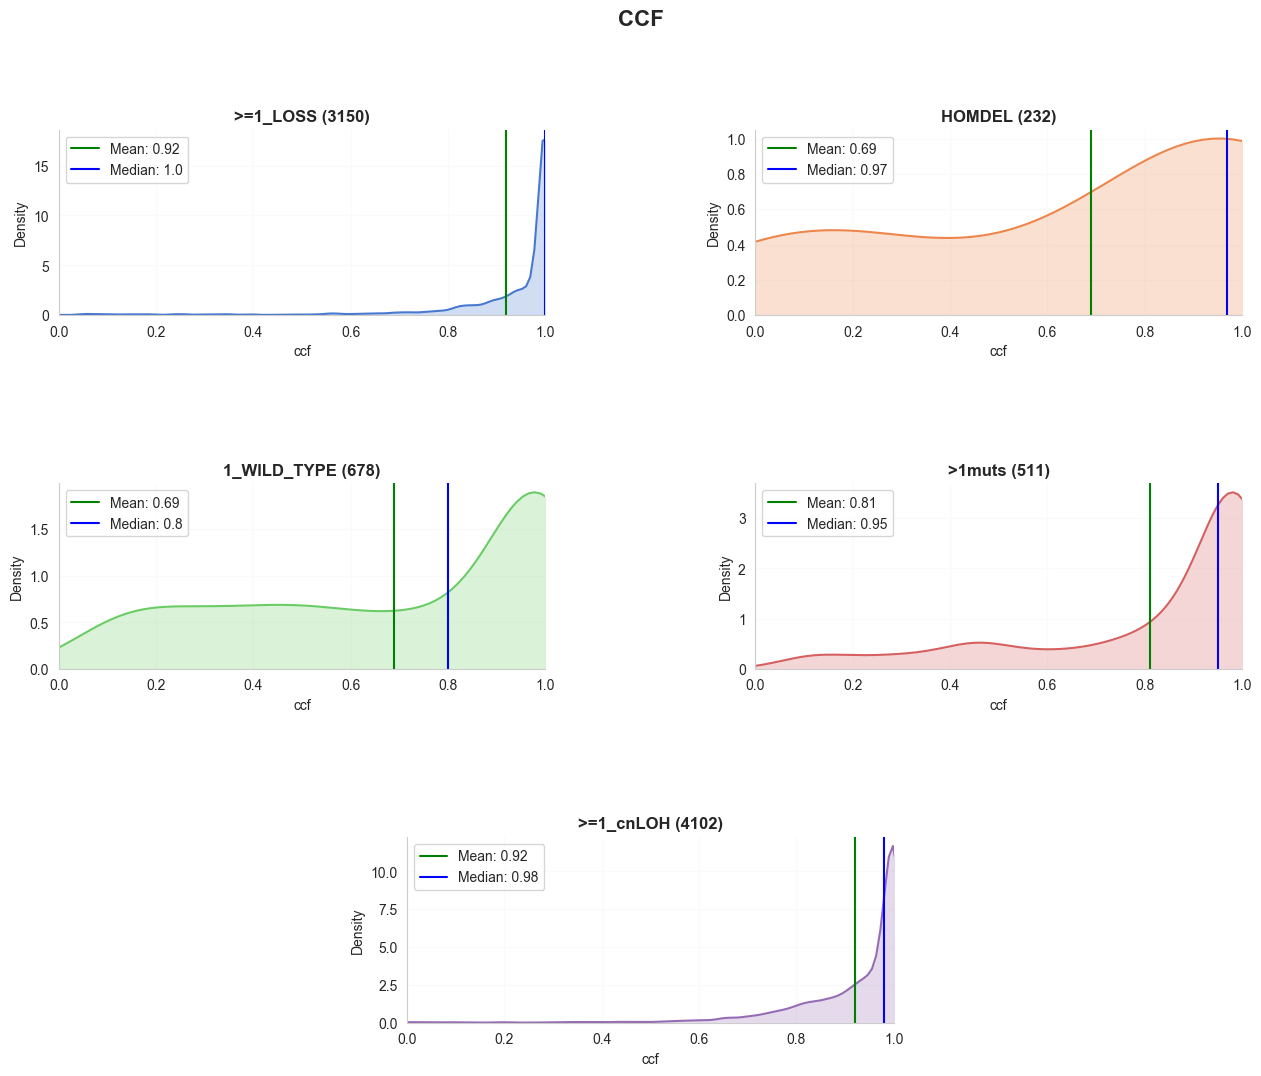

In [4]:
cut_master(master, range_ = [0.2,0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37, 0.4,0.6,0.8,1], threshold=0.30)

## Cutomized cut-off
Here we want to see the trade-off population lost | gain in purity if we have an assymetrical cut-off: a cut-off art 0.20 or 0.25 for all groups and a higher cut-off for 1_WILD_TYPE

In [5]:
h = custom_cut_master(master, range_uniform = [0.20,0.20, 0.20, 0.20, 0.20,0.20,0.20, 0.20, 0.20, 0.20, 0.20,
                                               0.23,0.23, 0.23, 0.23, 0.23,0.23,0.23, 0.23, 0.23, 0.23, 0.23,
                                               0.25,0.25, 0.25, 0.25, 0.25,0.25,0.25, 0.25, 0.25, 0.25, 0.25,
                                               0.27,0.27, 0.27, 0.27, 0.27,0.27,0.27, 0.27, 0.27, 0.27, 0.27,
                                               1], 
                  range_custom = [0.25, 0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,
                                  0.25, 0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,
                                  0.25, 0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,
                                  0.25, 0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,
                                  1], 
                  threshold=0.30)
h.rename(columns={'range_custom':'WT_cut'})
h = h[['range_custom','>=1_cnLOH','>1muts','HOMDEL','>=1_LOSS','0_HETLOSS','1_WILD_TYPE','SUM','ratio','purity_median_interval']]
h

,range_custom,>=1_cnLOH,>1muts,HOMDEL,>=1_LOSS,0_HETLOSS,1_WILD_TYPE,SUM,ratio,purity_median_interval
0.20,0.25,124,41,6,71,49,560,851,5.9,"[0.37, 0.52]"
0.20,0.26,124,41,6,71,49,608,899,6.2,"[0.37, 0.52]"
0.20,0.27,124,41,6,71,49,662,953,6.6,"[0.39, 0.52]"
0.20,0.28,124,41,6,71,49,714,1005,7.0,"[0.4, 0.52]"
0.20,0.29,124,41,6,71,49,761,1052,7.3,"[0.41, 0.52]"
0.20,0.30,124,41,6,71,49,867,1158,8.0,"[0.45, 0.52]"
0.20,0.31,124,41,6,71,49,899,1190,8.3,"[0.45, 0.52]"
0.20,0.32,124,41,6,71,49,932,1223,8.5,"[0.45, 0.52]"
0.20,0.33,124,41,6,71,49,971,1262,8.8,"[0.45, 0.52]"
0.20,0.34,124,41,6,71,49,993,1284,8.9,"[0.45, 0.52]"


# Checking Purity | Number of chromosomes affected

The question is: Is there some correlations or relations between # of chromosomes affected and the purity? Indeed purity is assessed thanks to the number of CN events, so the purity might be less accurate (underestimated or overestimated) with a low # of chr affected.

So we plot the topography of chr_affected|purity along with univariate densities

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec, title):
        self.fig = fig
        self.sg = seaborngrid
        self.title = title
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

    def set_title(self, title="", **kwargs):
        """ Set the title of the figure

        Parameters
        ----------
        title : string
            Title for the figure
        kwargs : key, value mappings

        Returns
        -------
        self : JointGrid instance
            returns `self`
        """
        self.sg.ax_joint.set_title(title, **kwargs)
        return self


def get_jointplots_subgroups(df:pd.DataFrame, metrics:list, met_prim:str = None, figsize=(15,12), cancer_type=None):
    # We initialize the figure
    sns.set_style("whitegrid", {'grid.color': '1.'})
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, 2)
    groups = ['>=1_LOSS', 'HOMDEL', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '0_HETLOSS']
    gs.tight_layout(fig)
    
    if met_prim:
        df = df[df['Sample_Type'] == met_prim]
        
    if cancer_type:
        df = df[df['Cancer_Type'].isin(cancer_type)]
        
    # To have the numbers per group
    h = get_groupby(df, 'tp53_group', 'count')
    numbers = []
    for group in groups:
        numbers.append(int(h[h.index == group]['count']))
    cancer_number = [i + ' (' + str(j) + ')' for i, j in zip(groups, numbers)]

    
    for group,i in zip(groups, range(len(groups))):
        data = df[df['tp53_group'] == group]
        
        g = sns.jointplot(metrics[0], metrics[1], data=data, kind="kde", space=0, color=my_colors[i])
        g.ax_marg_y.set_ylim(-2, 32)
        g.ax_marg_x.set_xlim(0, 1)
        mg = SeabornFig2Grid(g, fig, gs[i], cancer_number[i])
        mg.set_title(cancer_number[i], pad=-5, weight = 'bold')
    gs.tight_layout(fig)
    
    return fig

## Joint plot chr_affected | purity

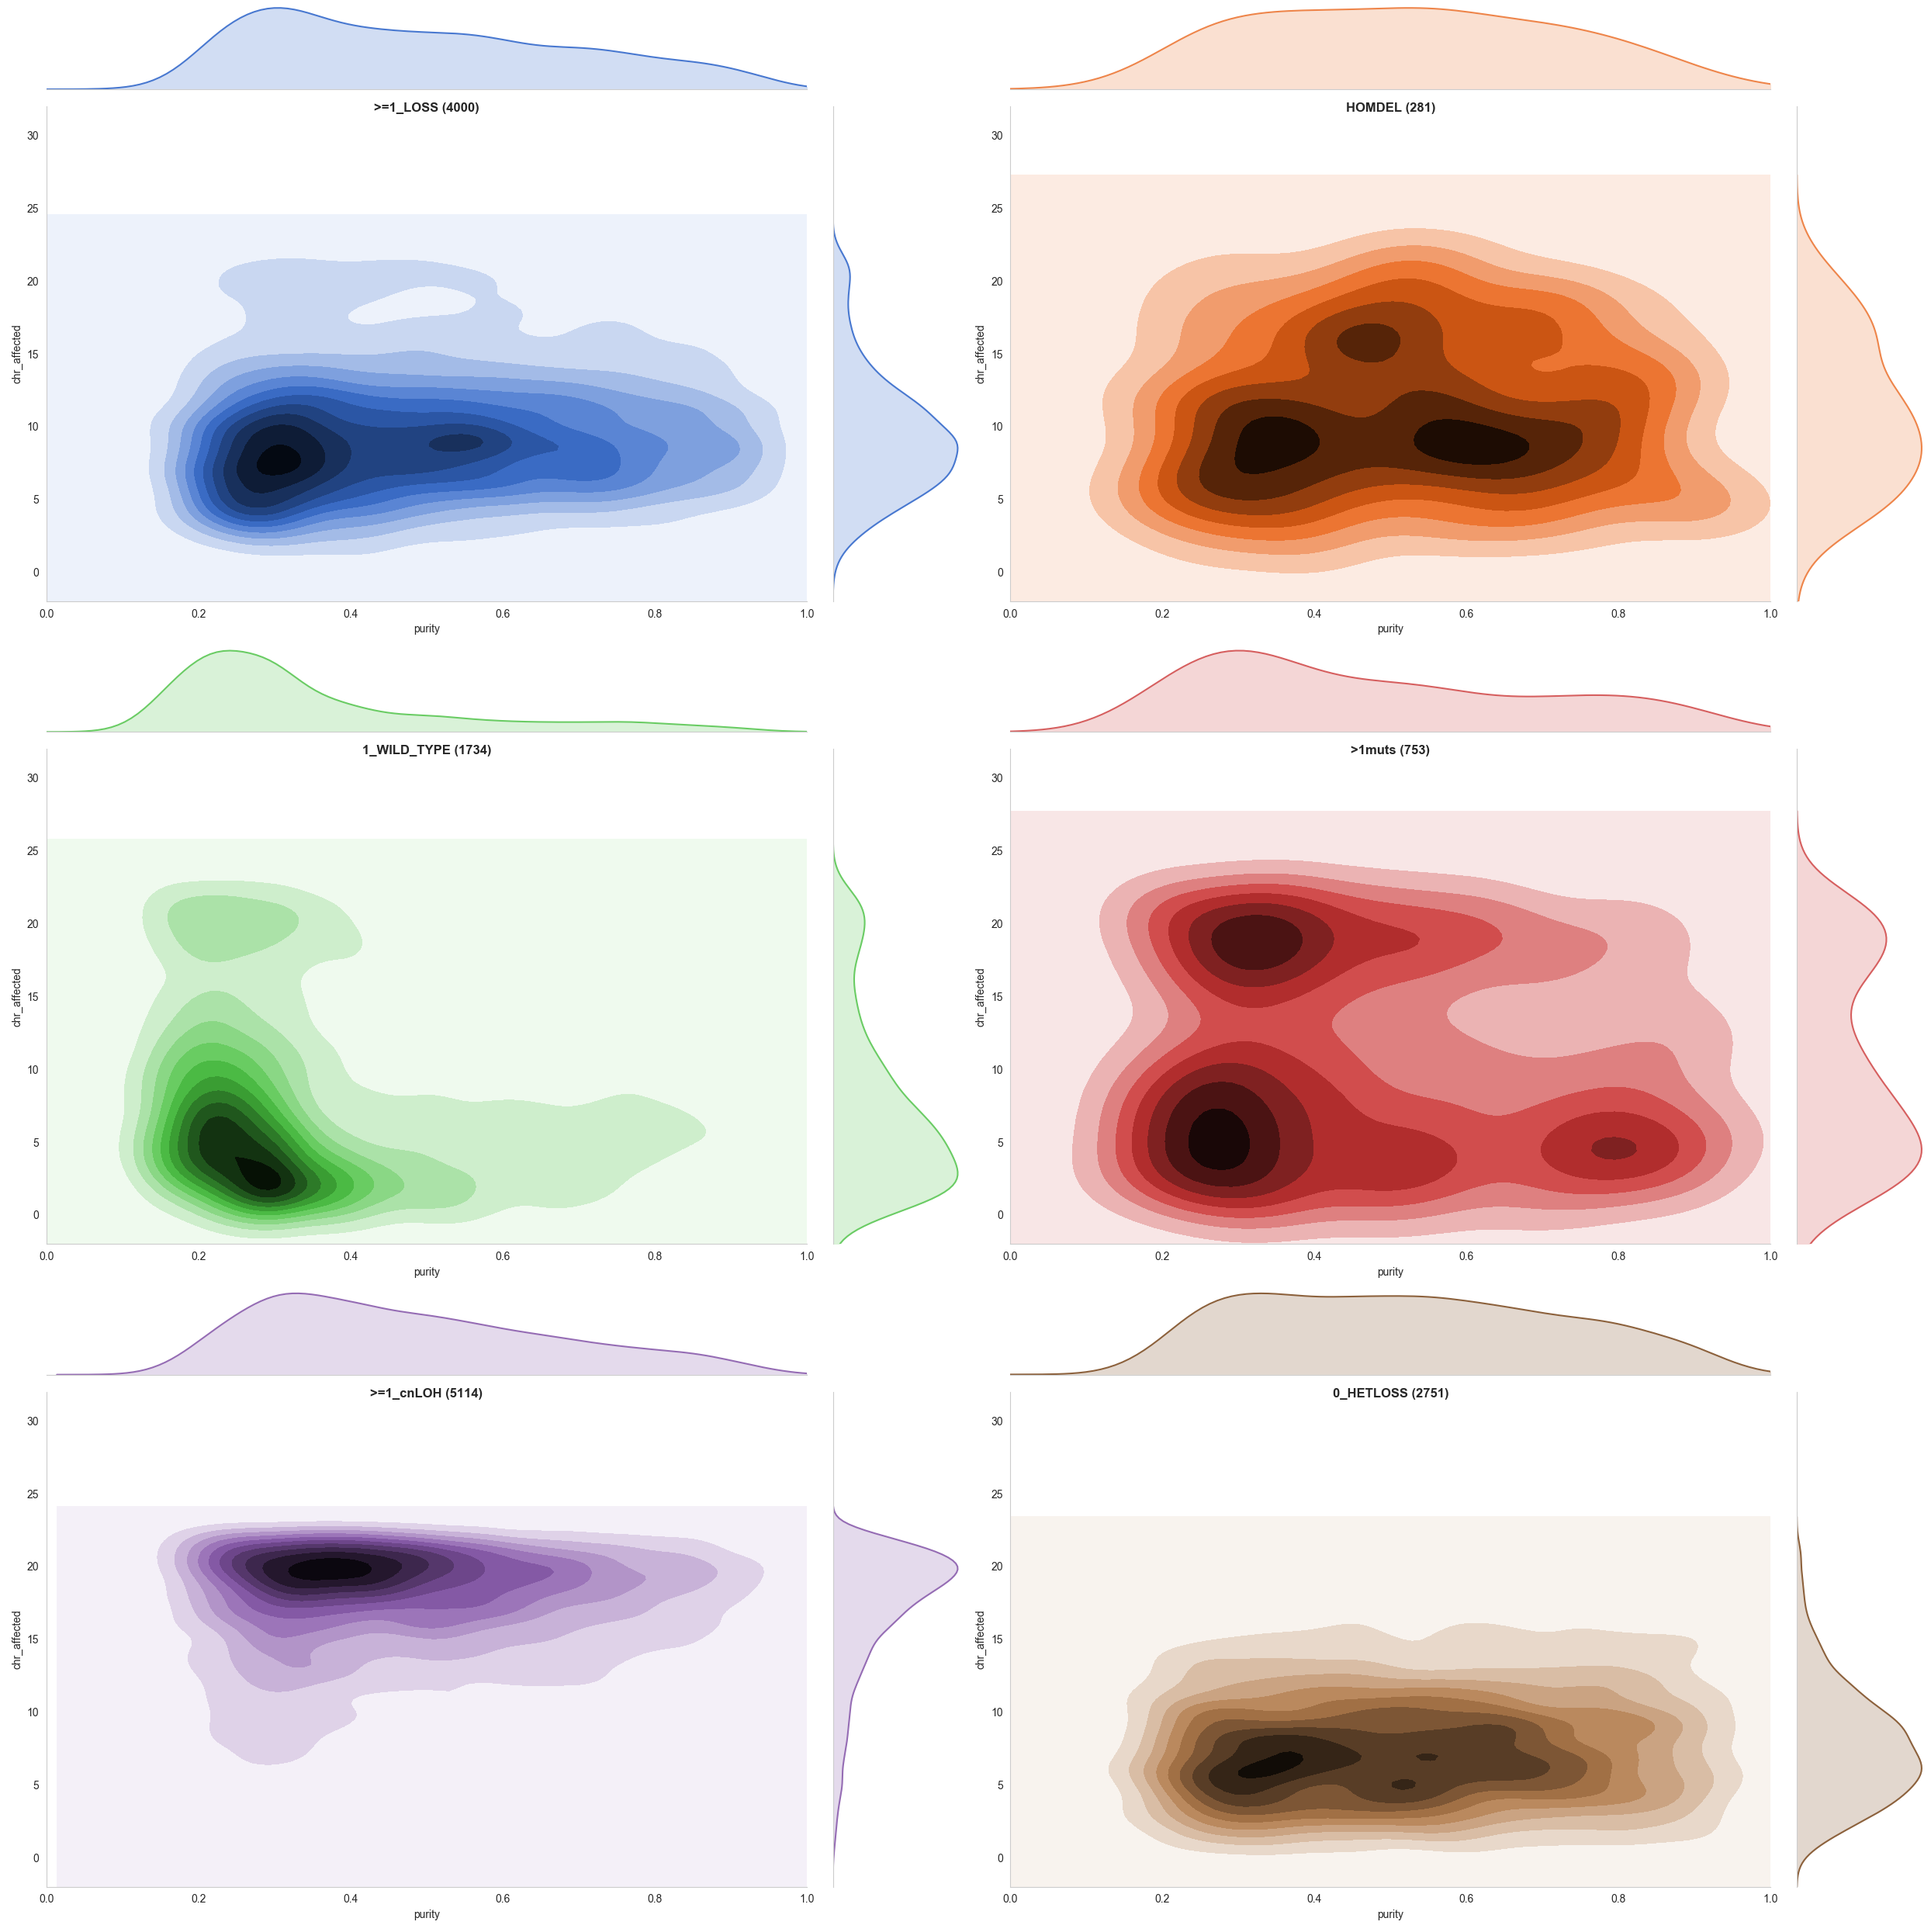

In [7]:
# All Samples
fig = get_jointplots_subgroups(master, 
             metrics=['purity', 'chr_affected'],   
             met_prim= None, 
             figsize=(25,25))

It seems that there is no clear relation between chr_affected and purity, it seems that a low number of affected chromosme does not imply a change in purity.

But to verify this assumption, we want to see if a low number of affected chromosomes (0 or 1) affects the purity distribution differences between the subgroups (focusing on the 1_WILD_TYPE subgroup)

## Effect of a low chr_affected on purity/max_vaf distributions

### Original purity/max_vaf

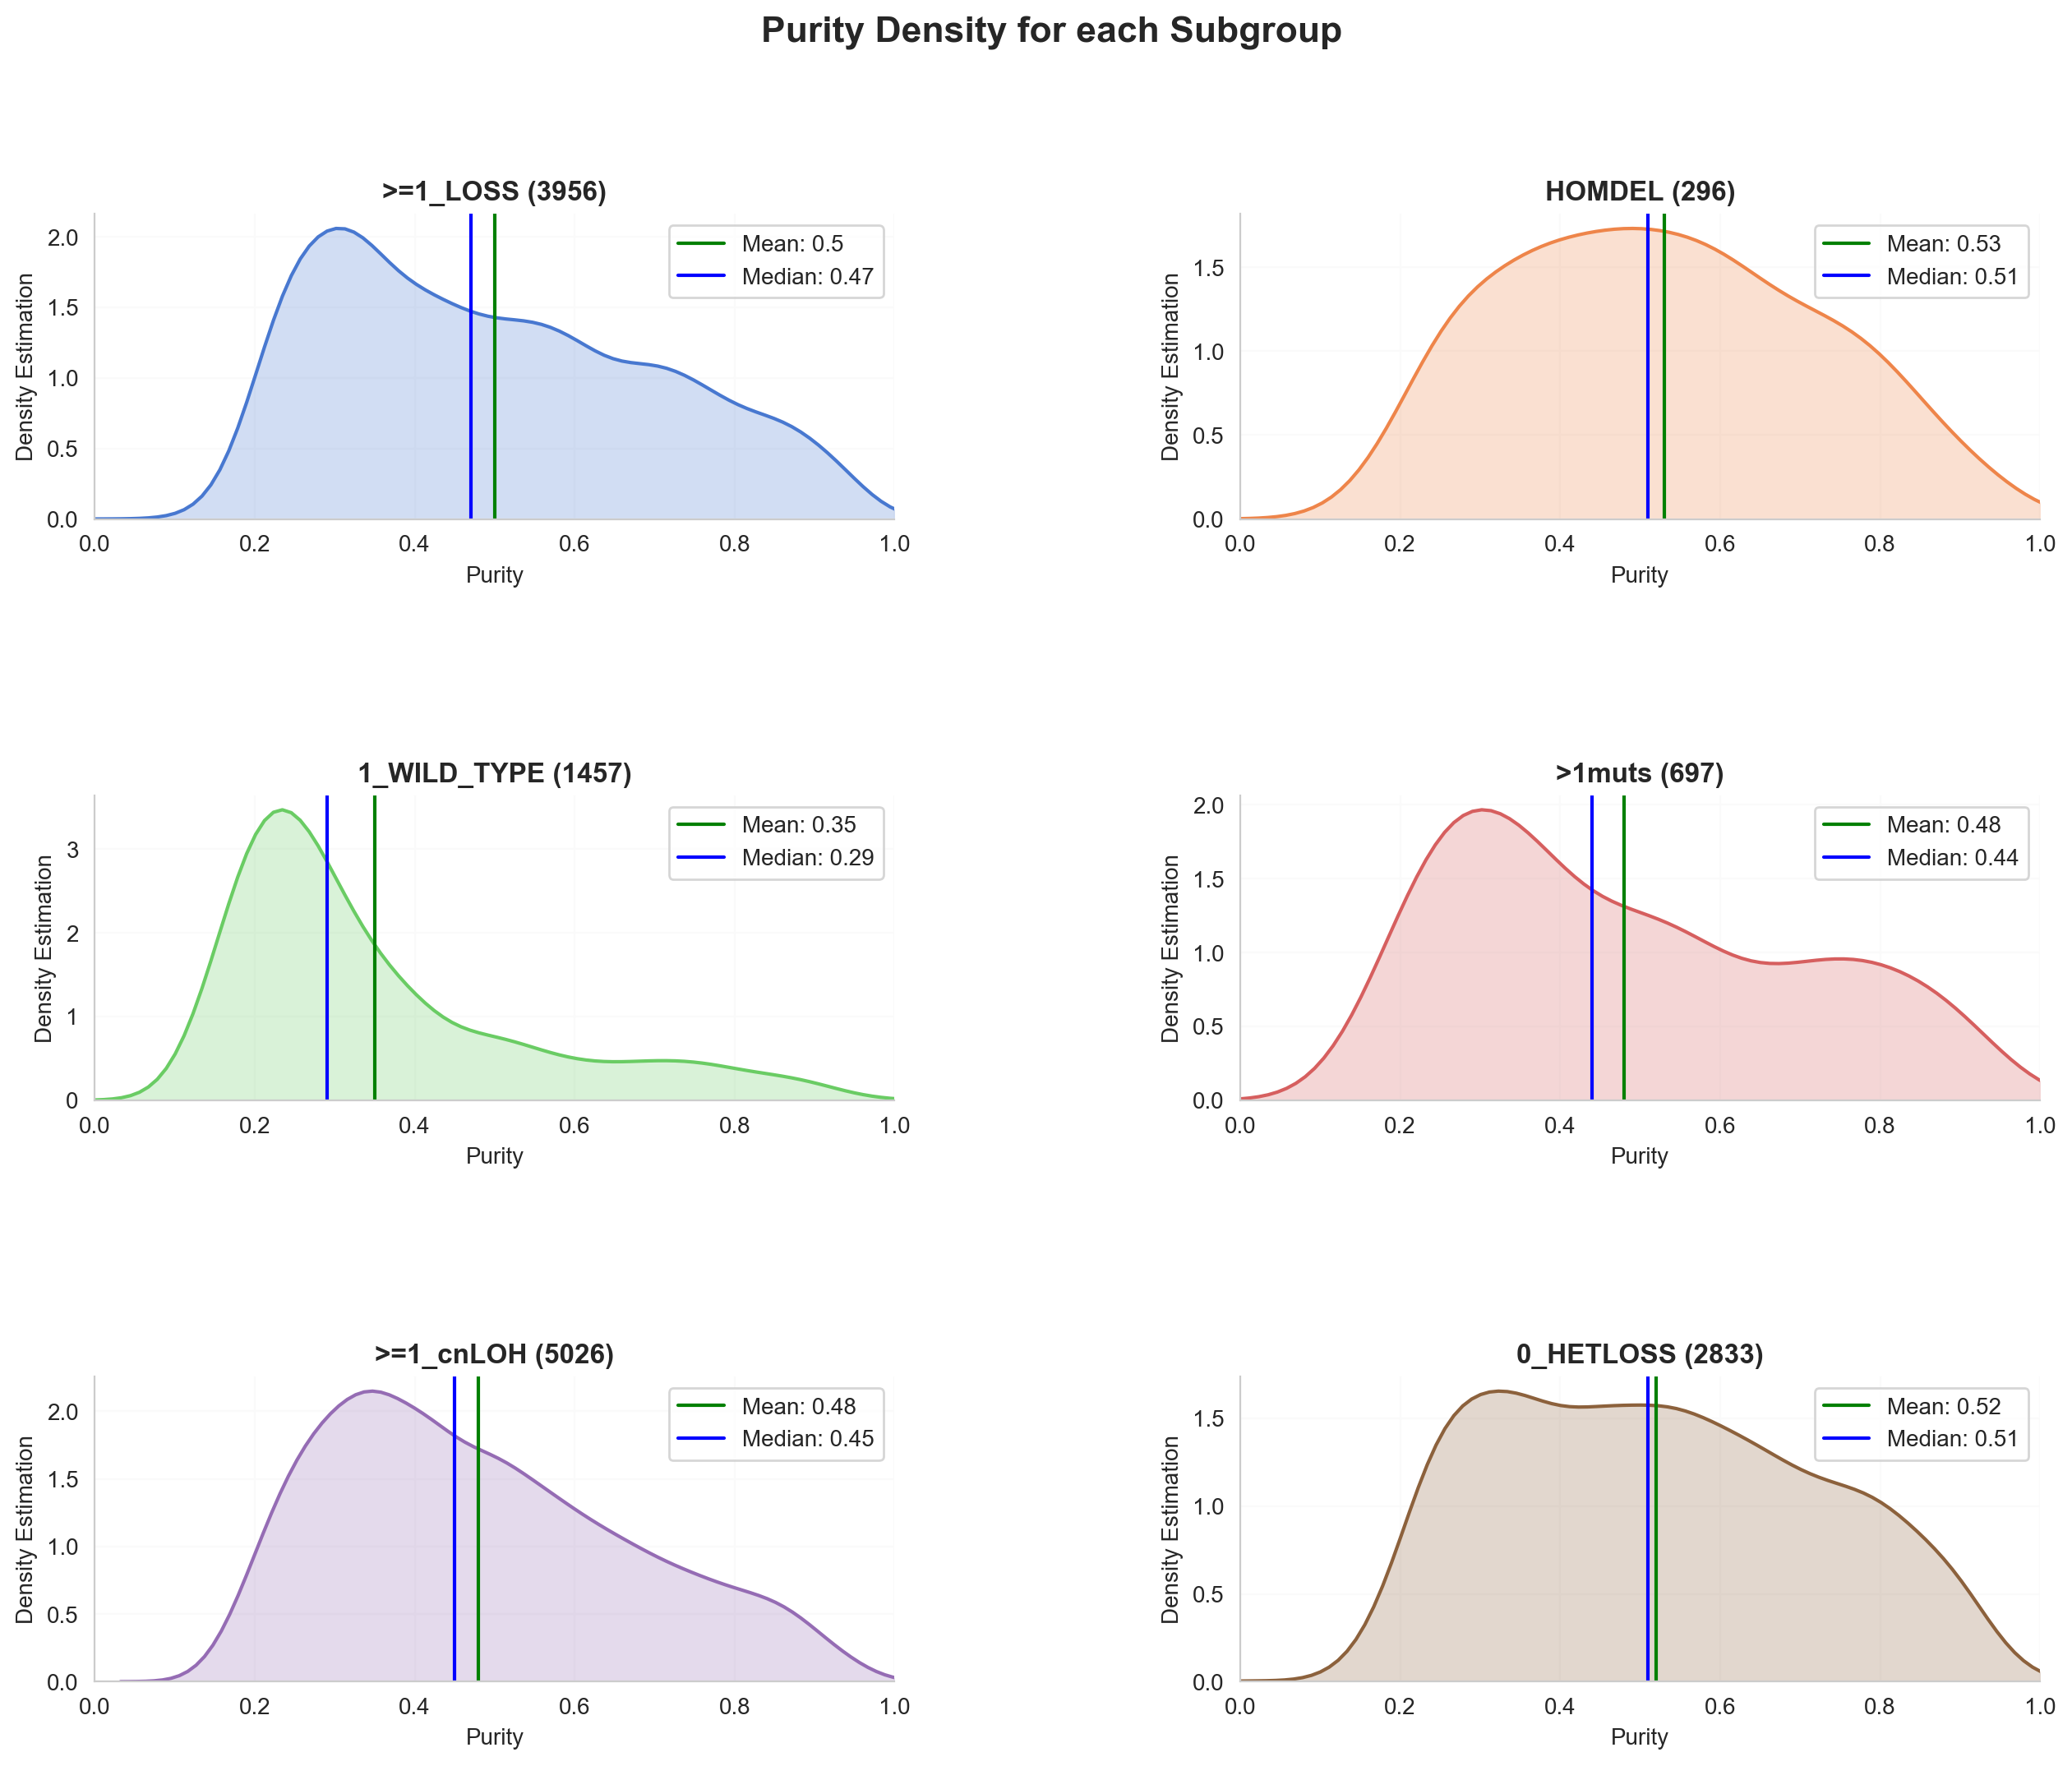

In [118]:
# Purity Comparison for all samples
get_densities(master, 'purity', fig_title='Purity Density for each Subgroup', xlabel='Purity', ylabel='Density Estimation',  number=6)

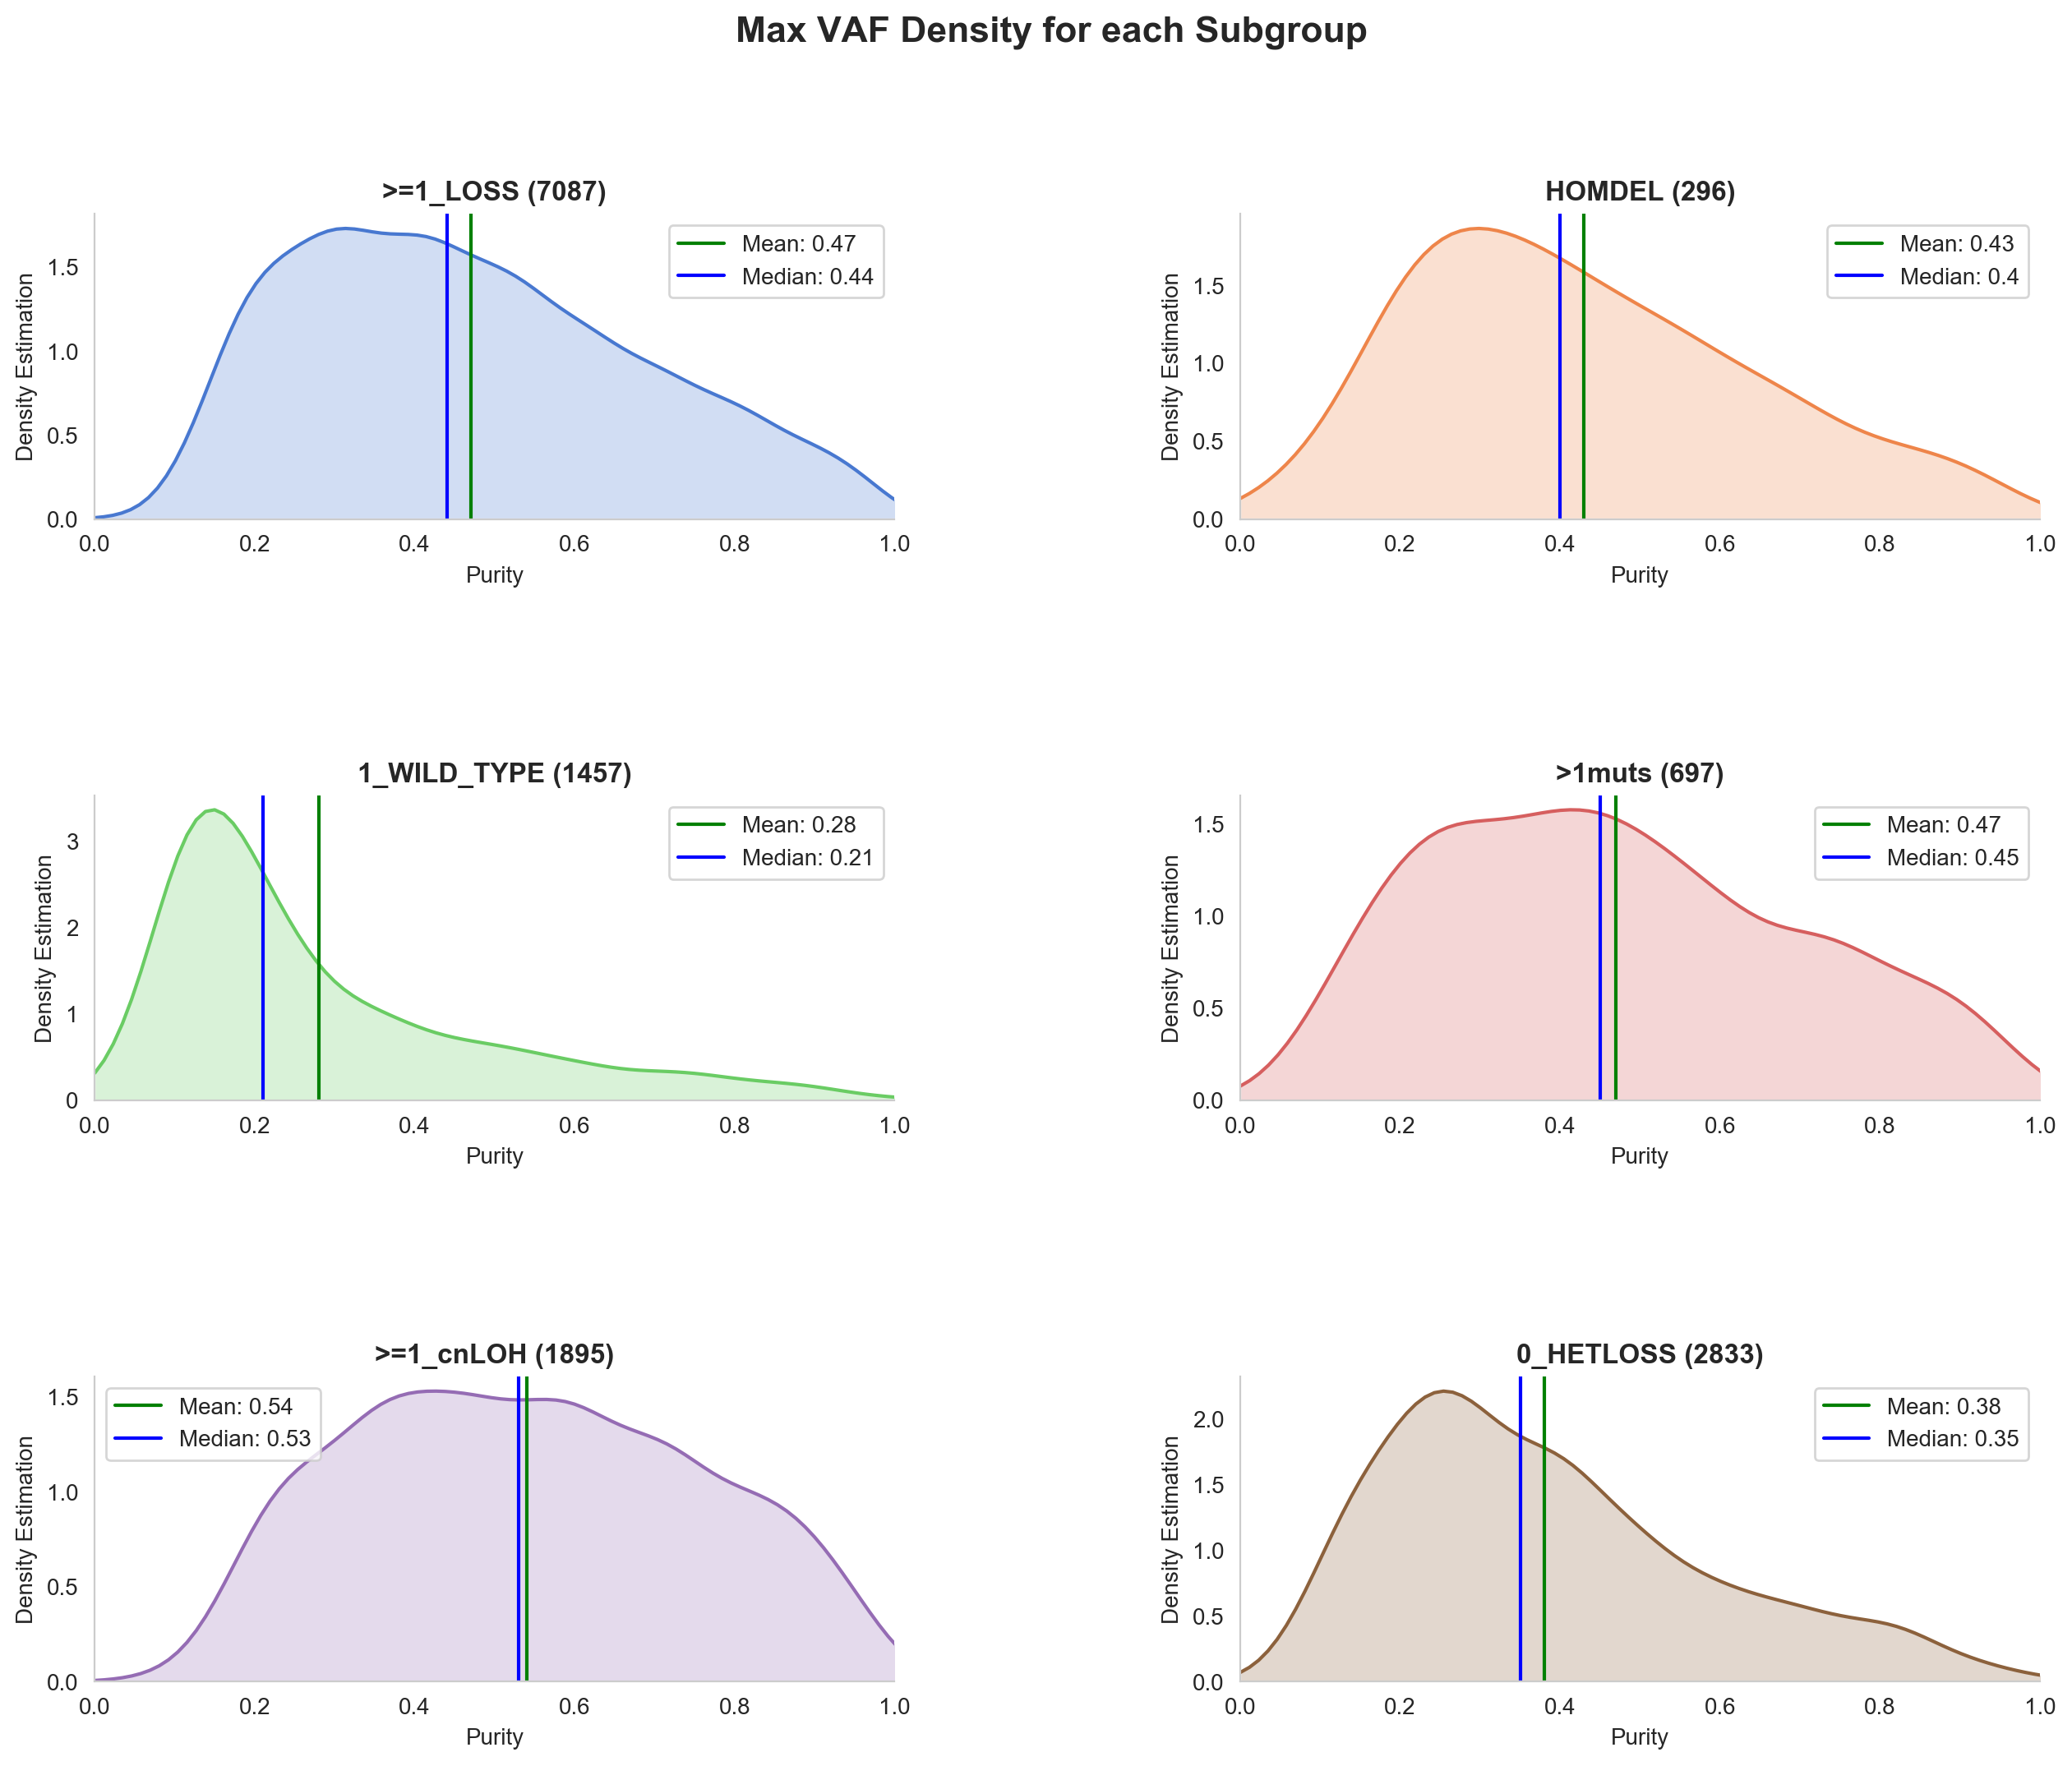

In [89]:
# max_vaf Comparison for all samples
get_densities(master, 'max_vaf', fig_title='Max VAF Density for each Subgroup', xlabel='Purity', ylabel='Density Estimation',  number=6)

### Purity/max_vaf for chr_affected = 0 or 1

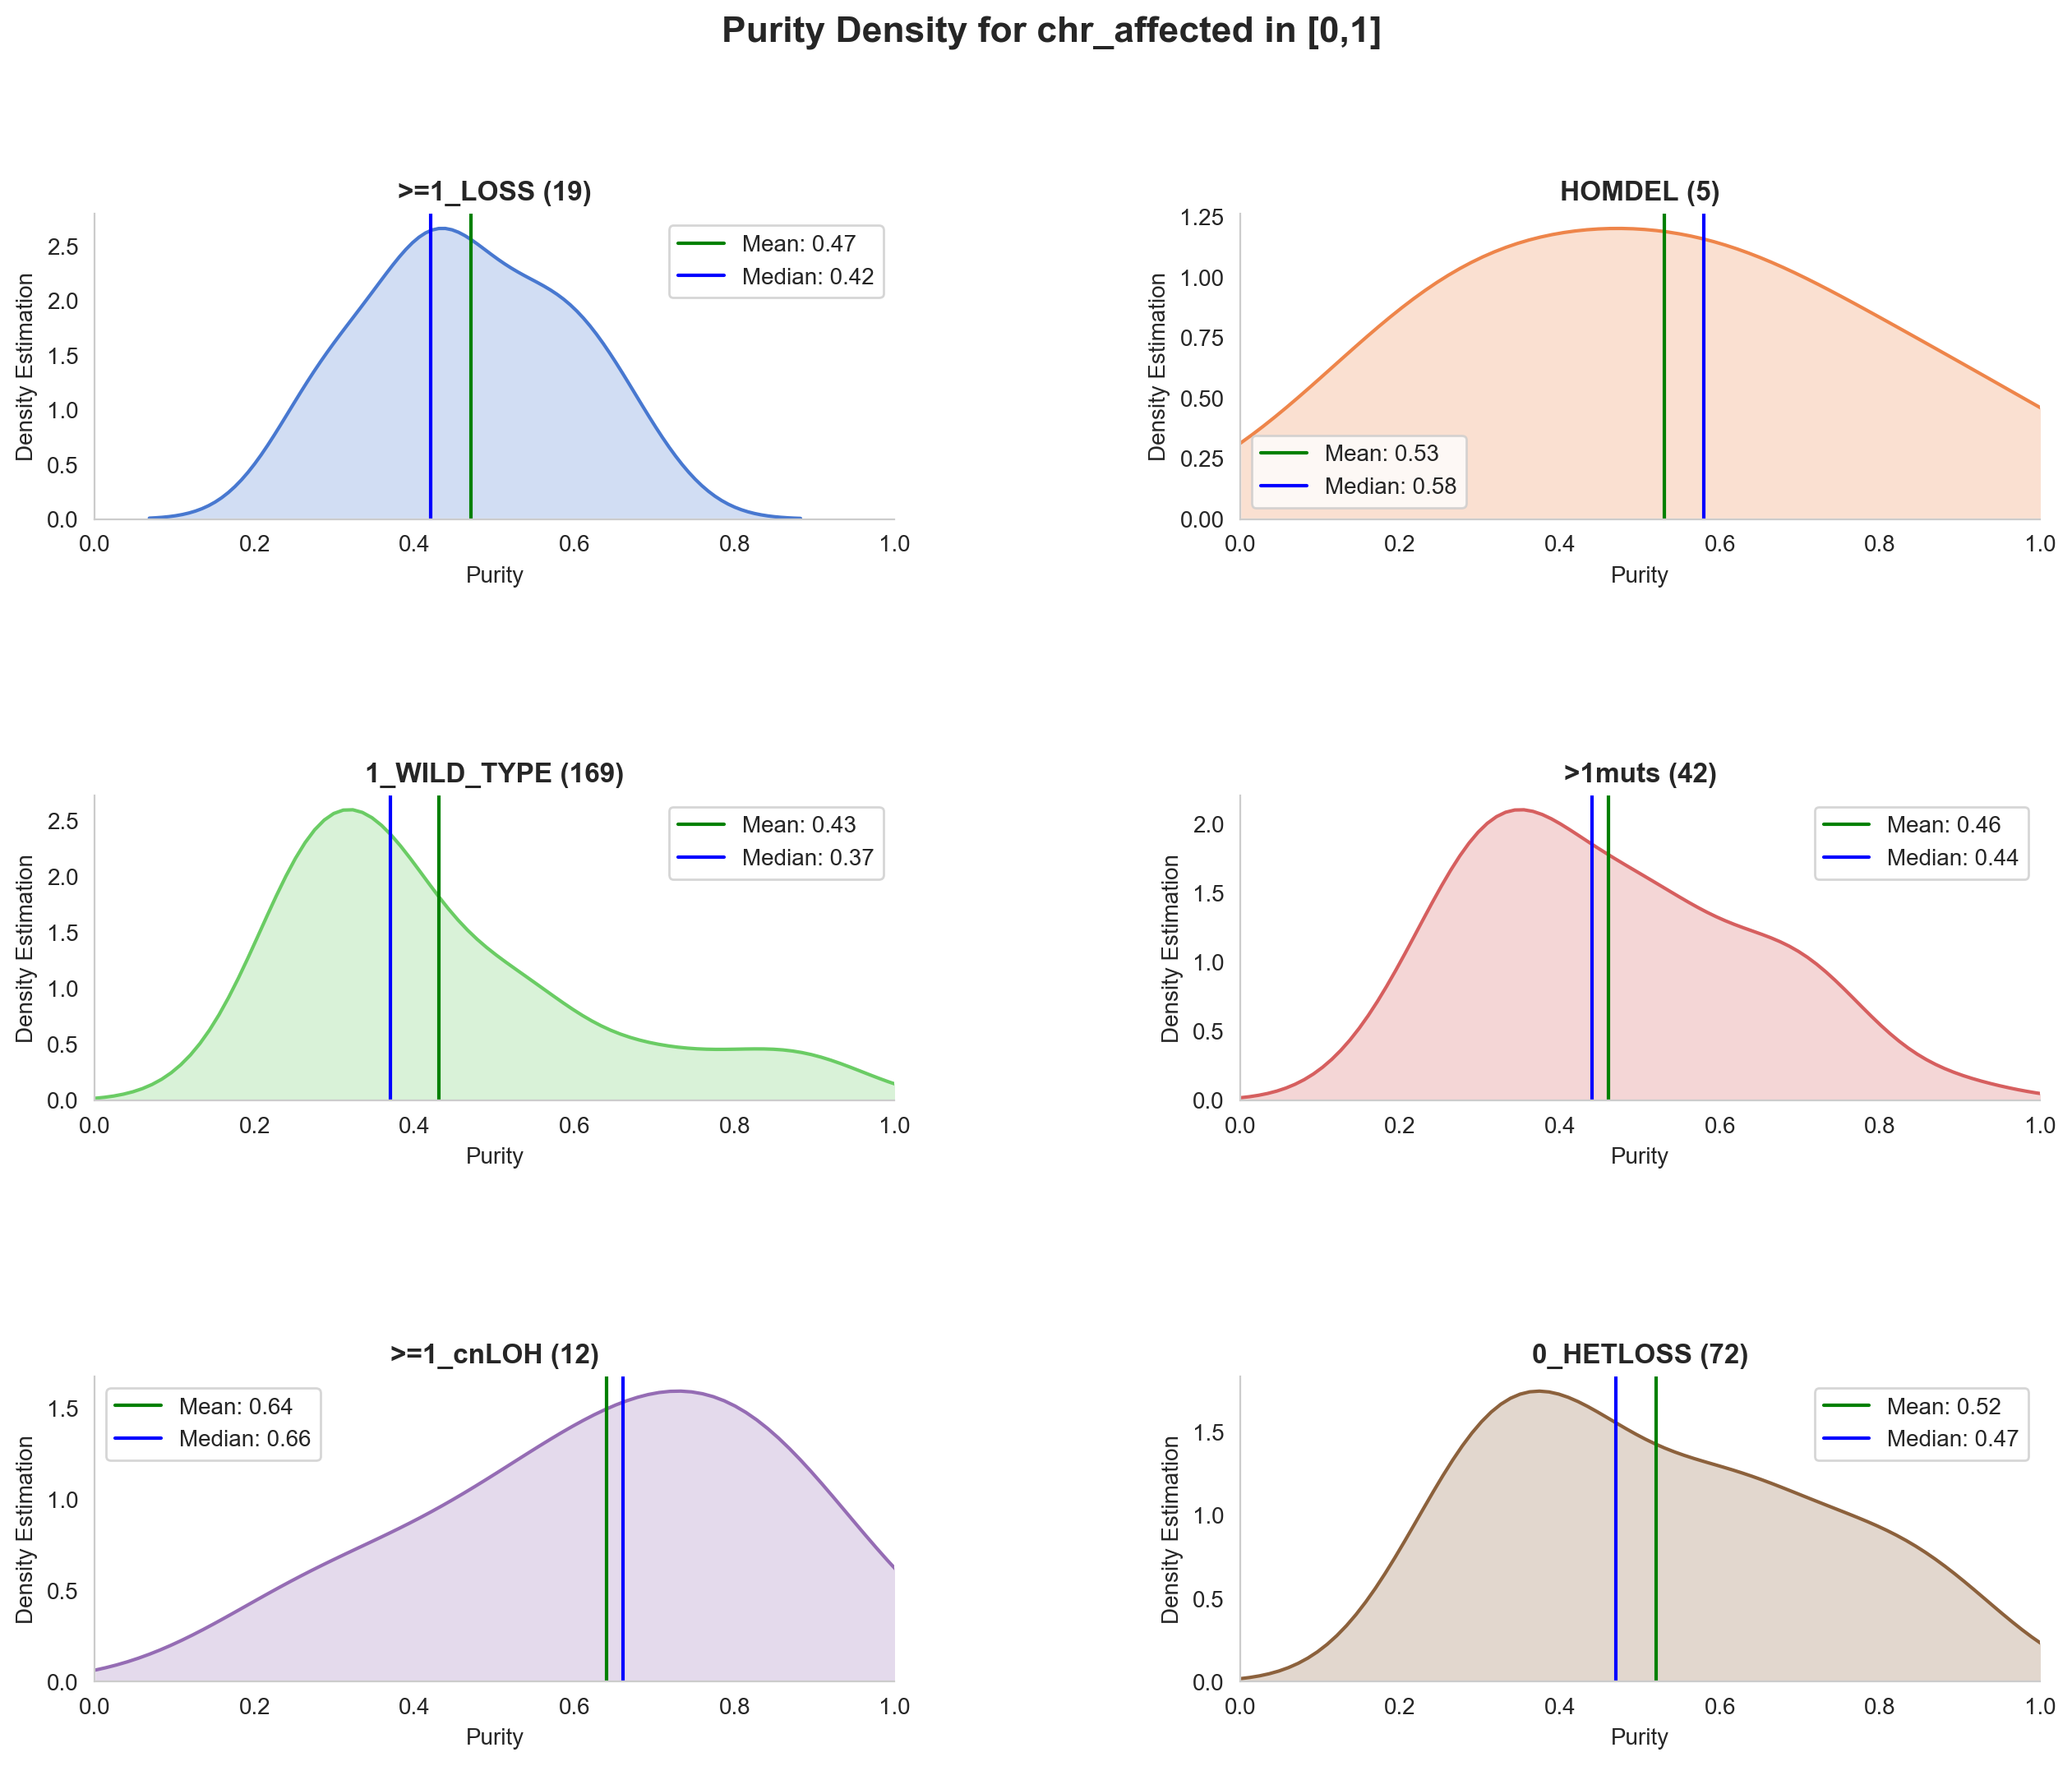

In [90]:
# Purity Comparison for all samples
master_01 = master[master['chr_affected'].isin([0,1])]
get_densities(master_01, 'purity', fig_title='Purity Density for chr_affected in [0,1]', xlabel='Purity', ylabel='Density Estimation',  number=6)

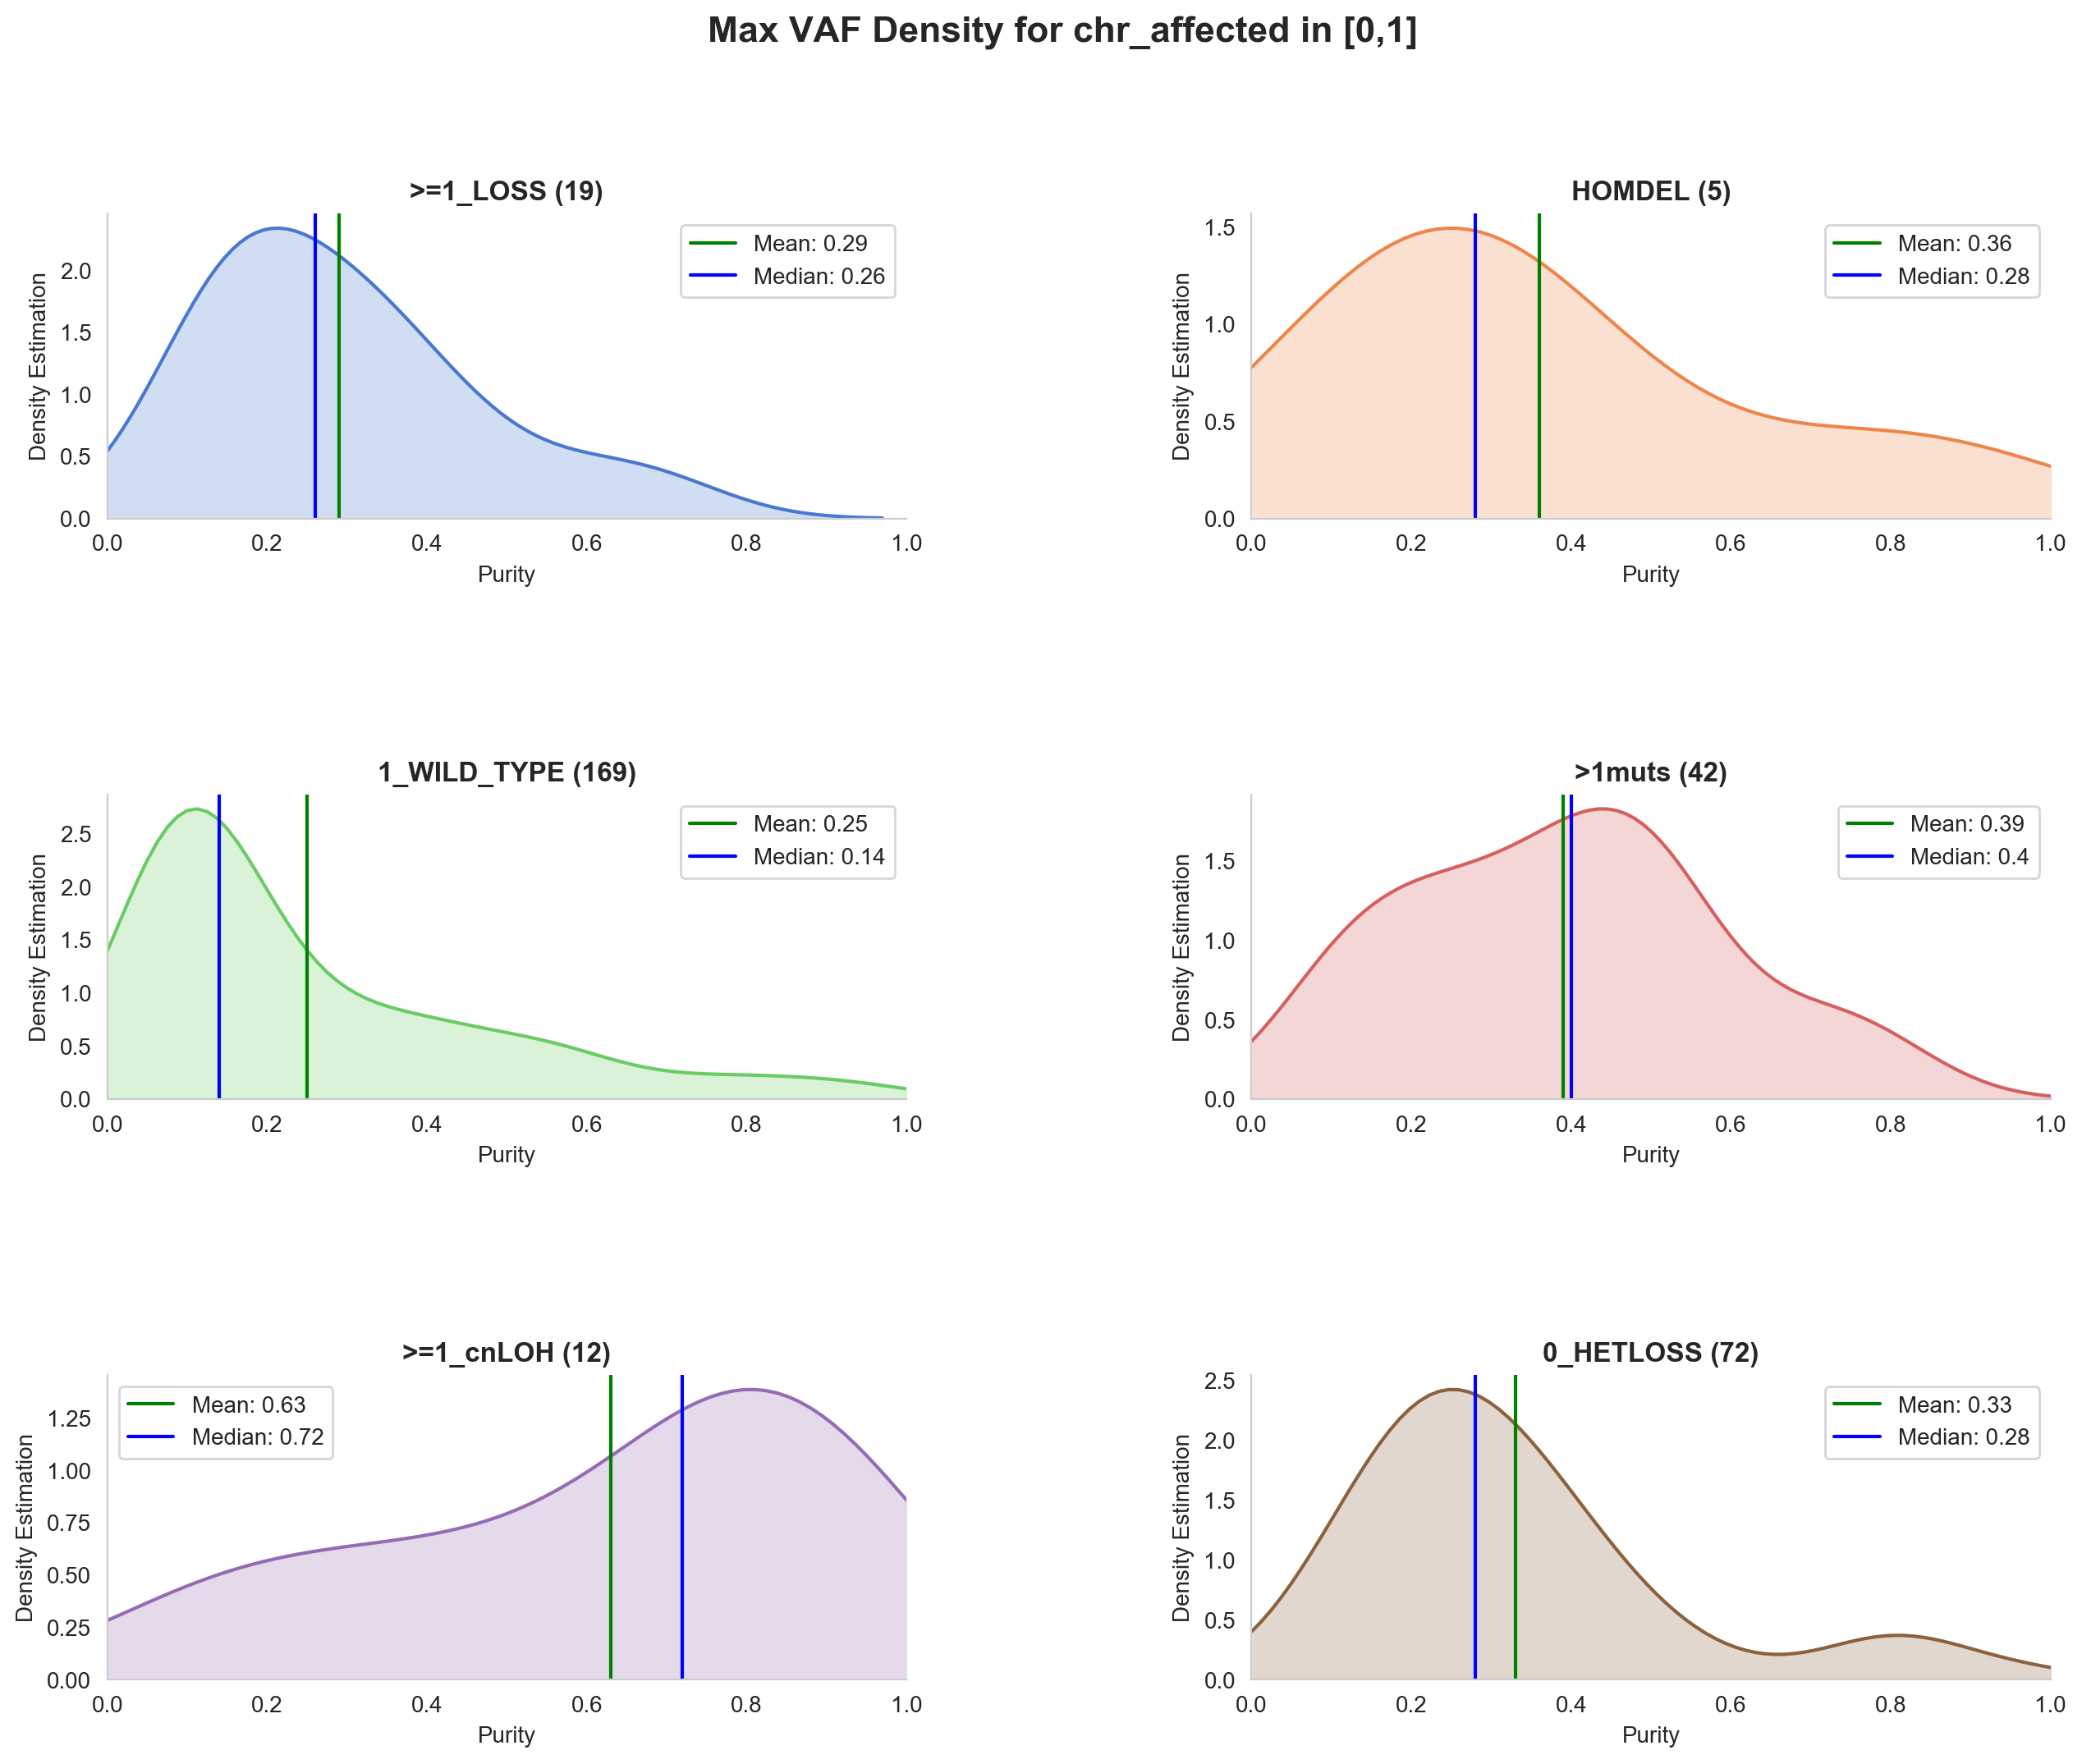

In [91]:
# Purity Comparison for all samples
master_01 = master[master['chr_affected'].isin([0,1])]
get_densities(master_01, 'max_vaf', fig_title='Max VAF Density for chr_affected in [0,1]', xlabel='Purity', ylabel='Density Estimation',  number=6)

### Purity/max_vaf for chr_affected = 2 or 3

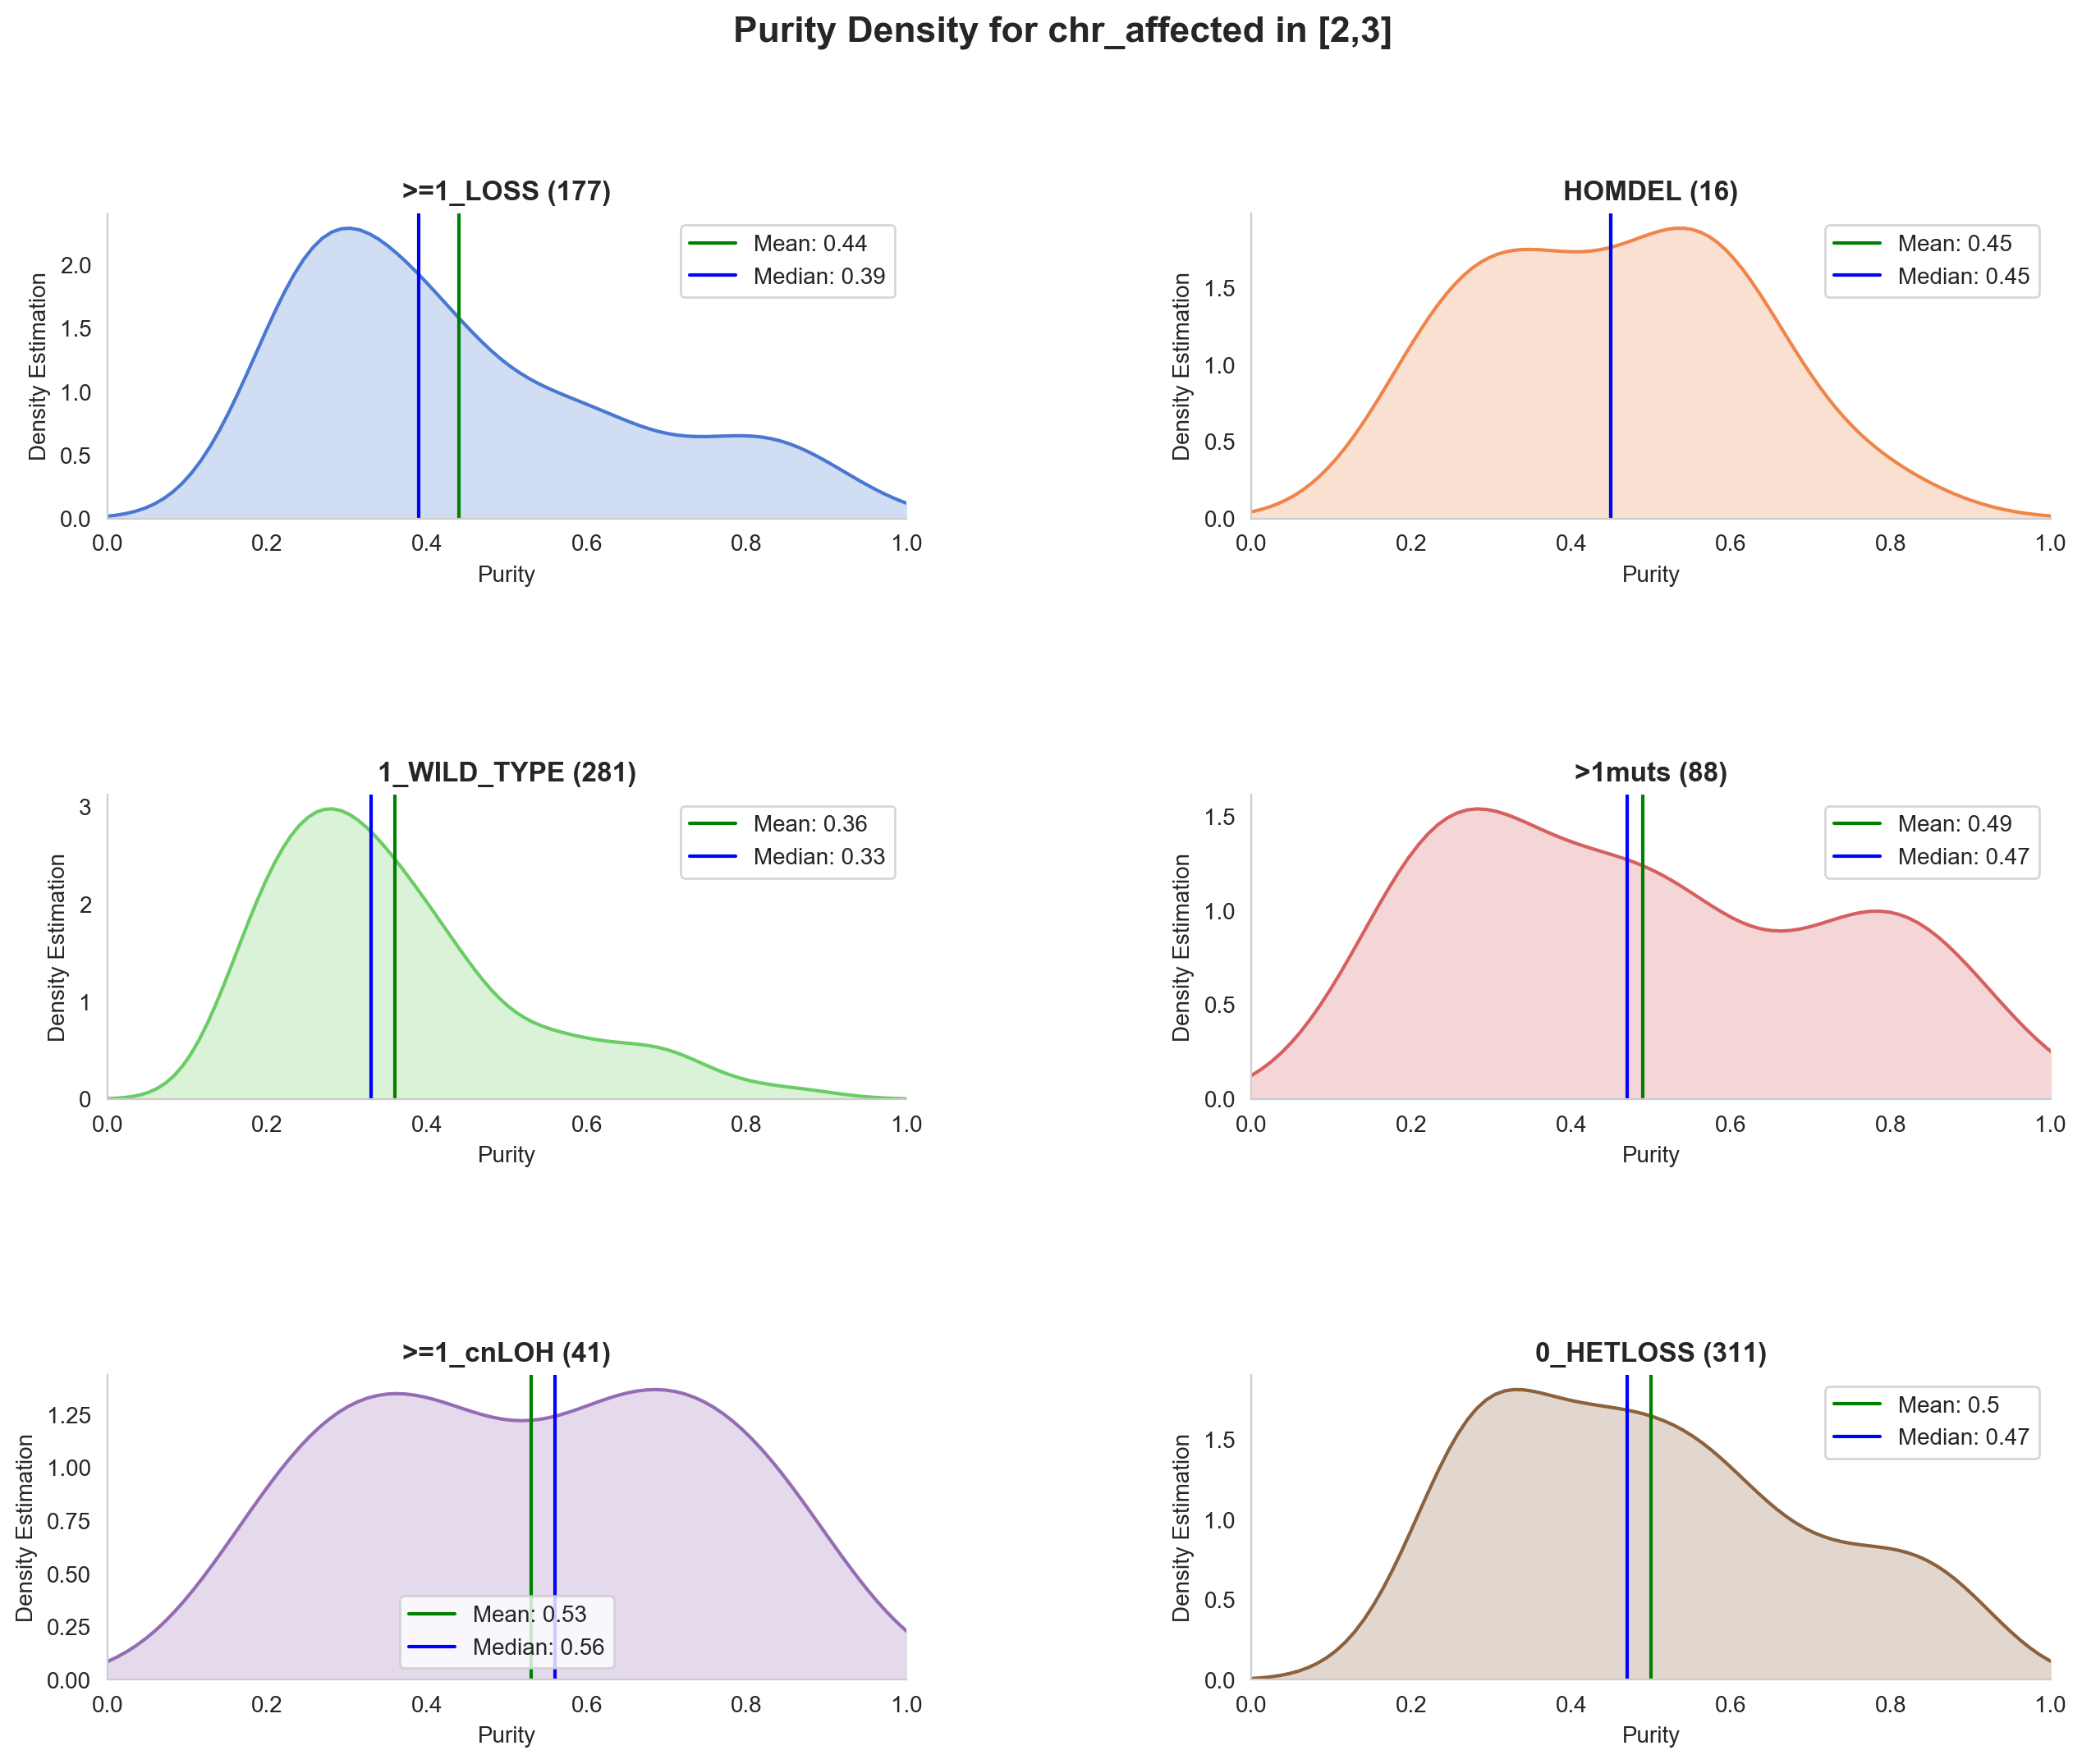

In [92]:
# Purity Comparison for all samples
master_23 = master[master['chr_affected'].isin([2,3])]
get_densities(master_23, 'purity', fig_title='Purity Density for chr_affected in [2,3]', xlabel='Purity', ylabel='Density Estimation',  number=6)

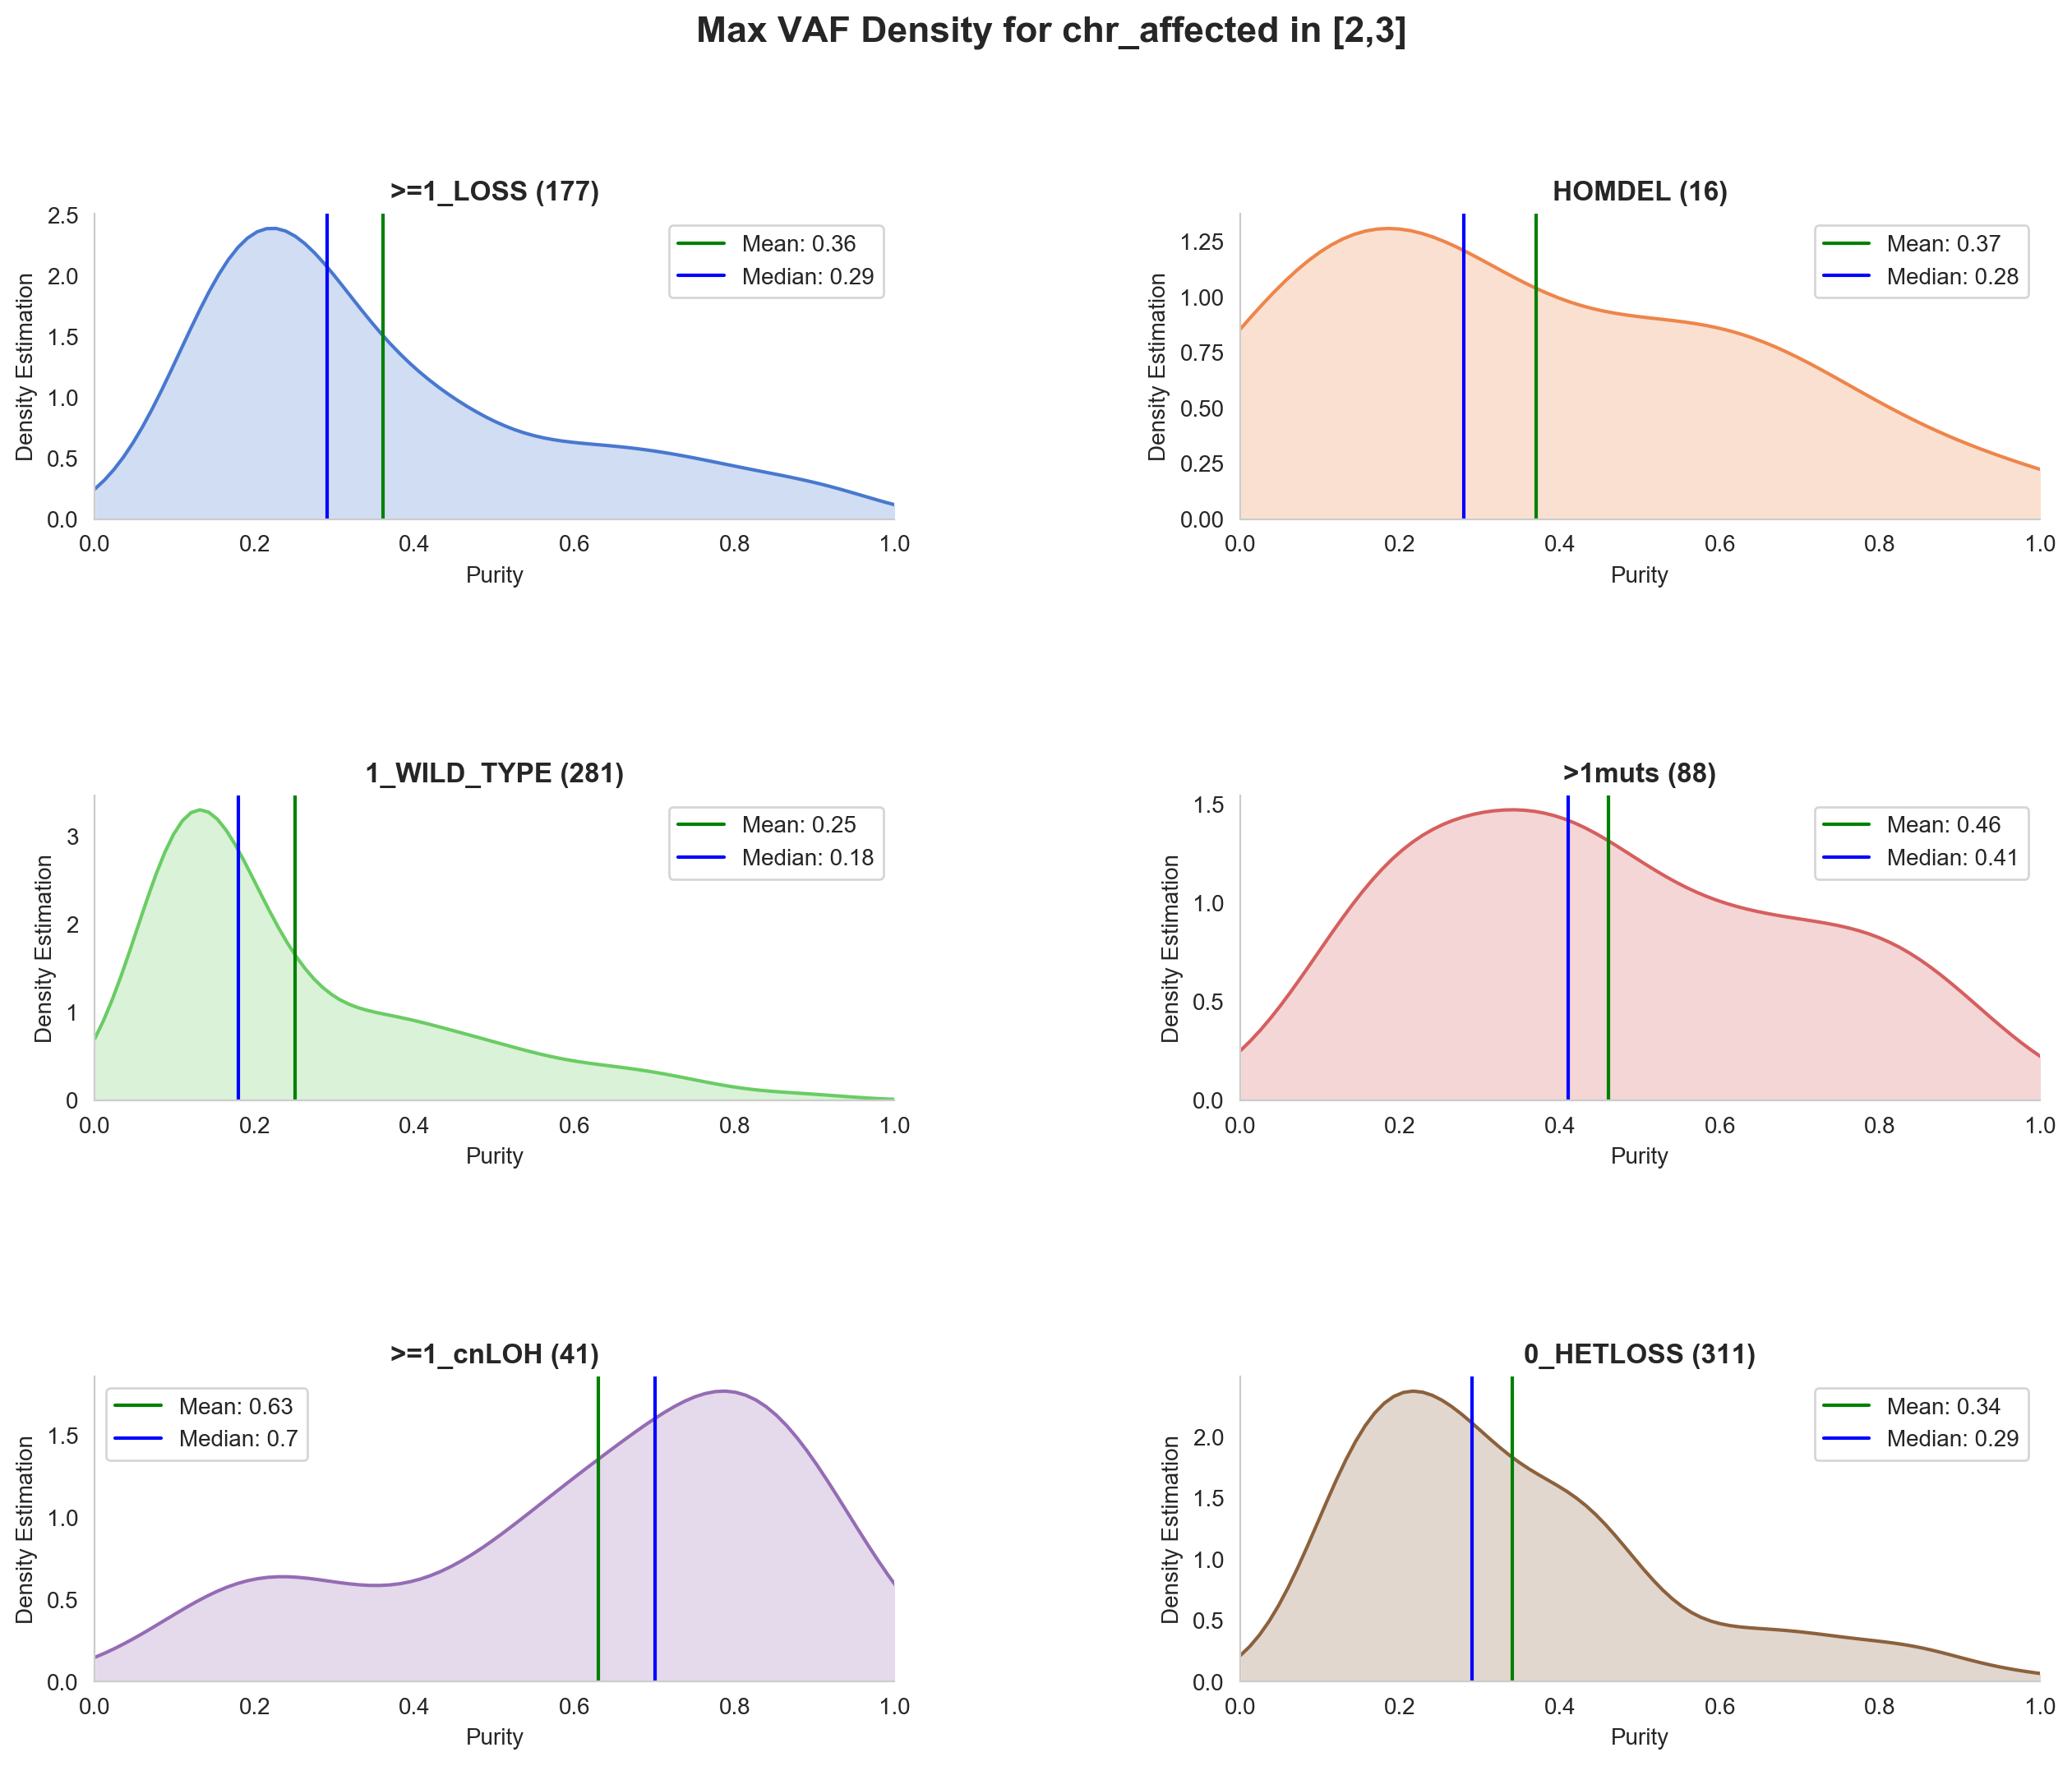

In [93]:
# Purity Comparison for all samples
master_23 = master[master['chr_affected'].isin([2,3])]
get_densities(master_23, 'max_vaf', fig_title='Max VAF Density for chr_affected in [2,3]', xlabel='Purity', ylabel='Density Estimation',  number=6)

# Cleaning the 1_WILD_TYPE subgroup

We want to ensure that our 1_WILD_TYPE subgroup only has 1 mutation per sample which implies that DIPLOID cn_state should have a vaf that is inferior to 0.5. So we will filter out all samples that are DIPLOID and have a tp53_vaf>0.6.

In [123]:
master['tp53_residual_1'] = master['tp53_tcn'] - master['tp53_exp_nb_1']
master['tp53_residual_2'] = master['tp53_tcn'] - master['tp53_exp_nb_2']
master['tp53_residual_3'] = master['tp53_tcn'] - master['tp53_exp_nb_3']
master['tp53_residual_4'] = master['tp53_tcn'] - master['tp53_exp_nb_4']
master['tp53_residual_5'] = master['tp53_tcn'] - master['tp53_exp_nb_5']
master_cutoff = master[master['purity'] > 0.20]
master_cutoff.drop(master_cutoff[master_cutoff['tp53_group'] == '1_WILD_TYPE'][master_cutoff['purity'] <= 0.31].index , inplace=True)

>=1_LOSS 19430
HOMDEL 1460
1_WILD_TYPE 3165
>1muts 3290
>=1_cnLOH 24455


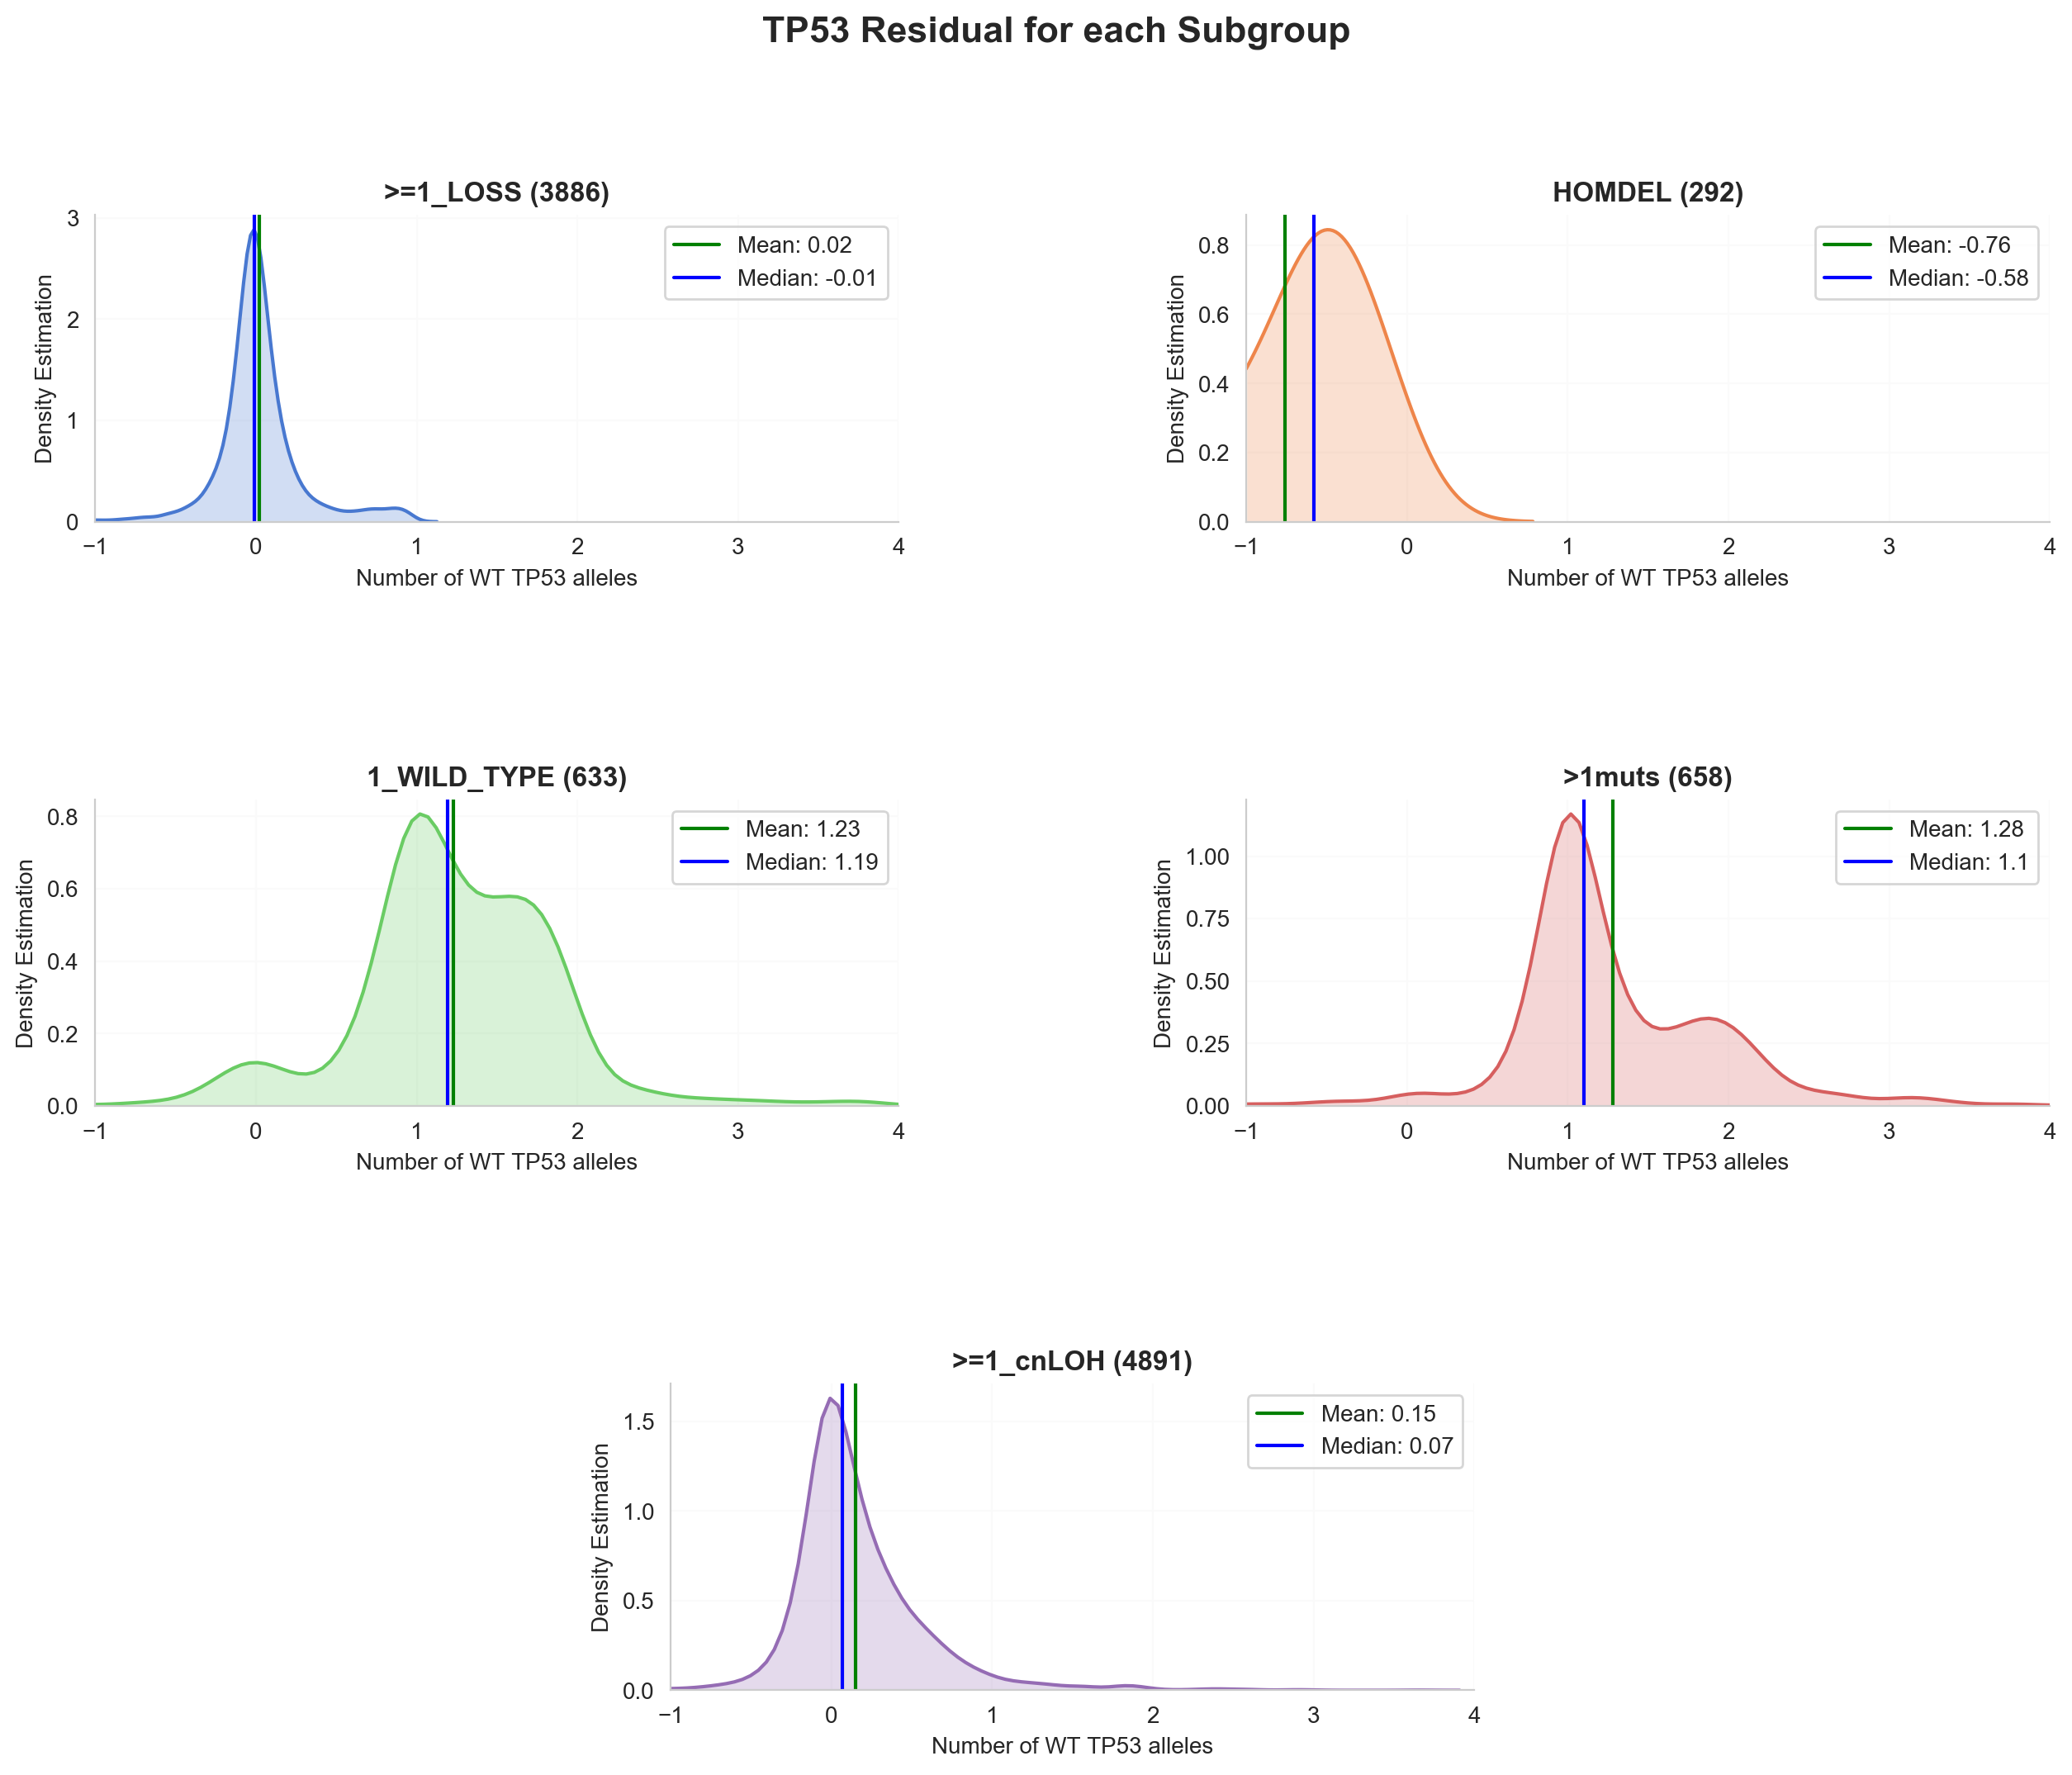

In [131]:
# For all Samples
get_densities(master_cutoff, 
              'tp53_residual', 
              fig_title='TP53 Residual for each Subgroup', 
              xlabel='Number of WT TP53 alleles', 
              ylabel='Density Estimation',  
              number=5,
              tp53_metrics=True,
              met_prim= None, 
              clip = (-1,4.0),
              x_lim =[-1,4])

In [132]:
master_cutoff_cleaned = master_cutoff
master_cutoff_cleaned.drop(master_cutoff_cleaned[master_cutoff_cleaned['tp53_group']=='1_WILD_TYPE'][master_cutoff_cleaned['tp53_cn_state']=='DIPLOID'][master_cutoff_cleaned['tp53_vaf_1']>0.6].index, inplace=True)

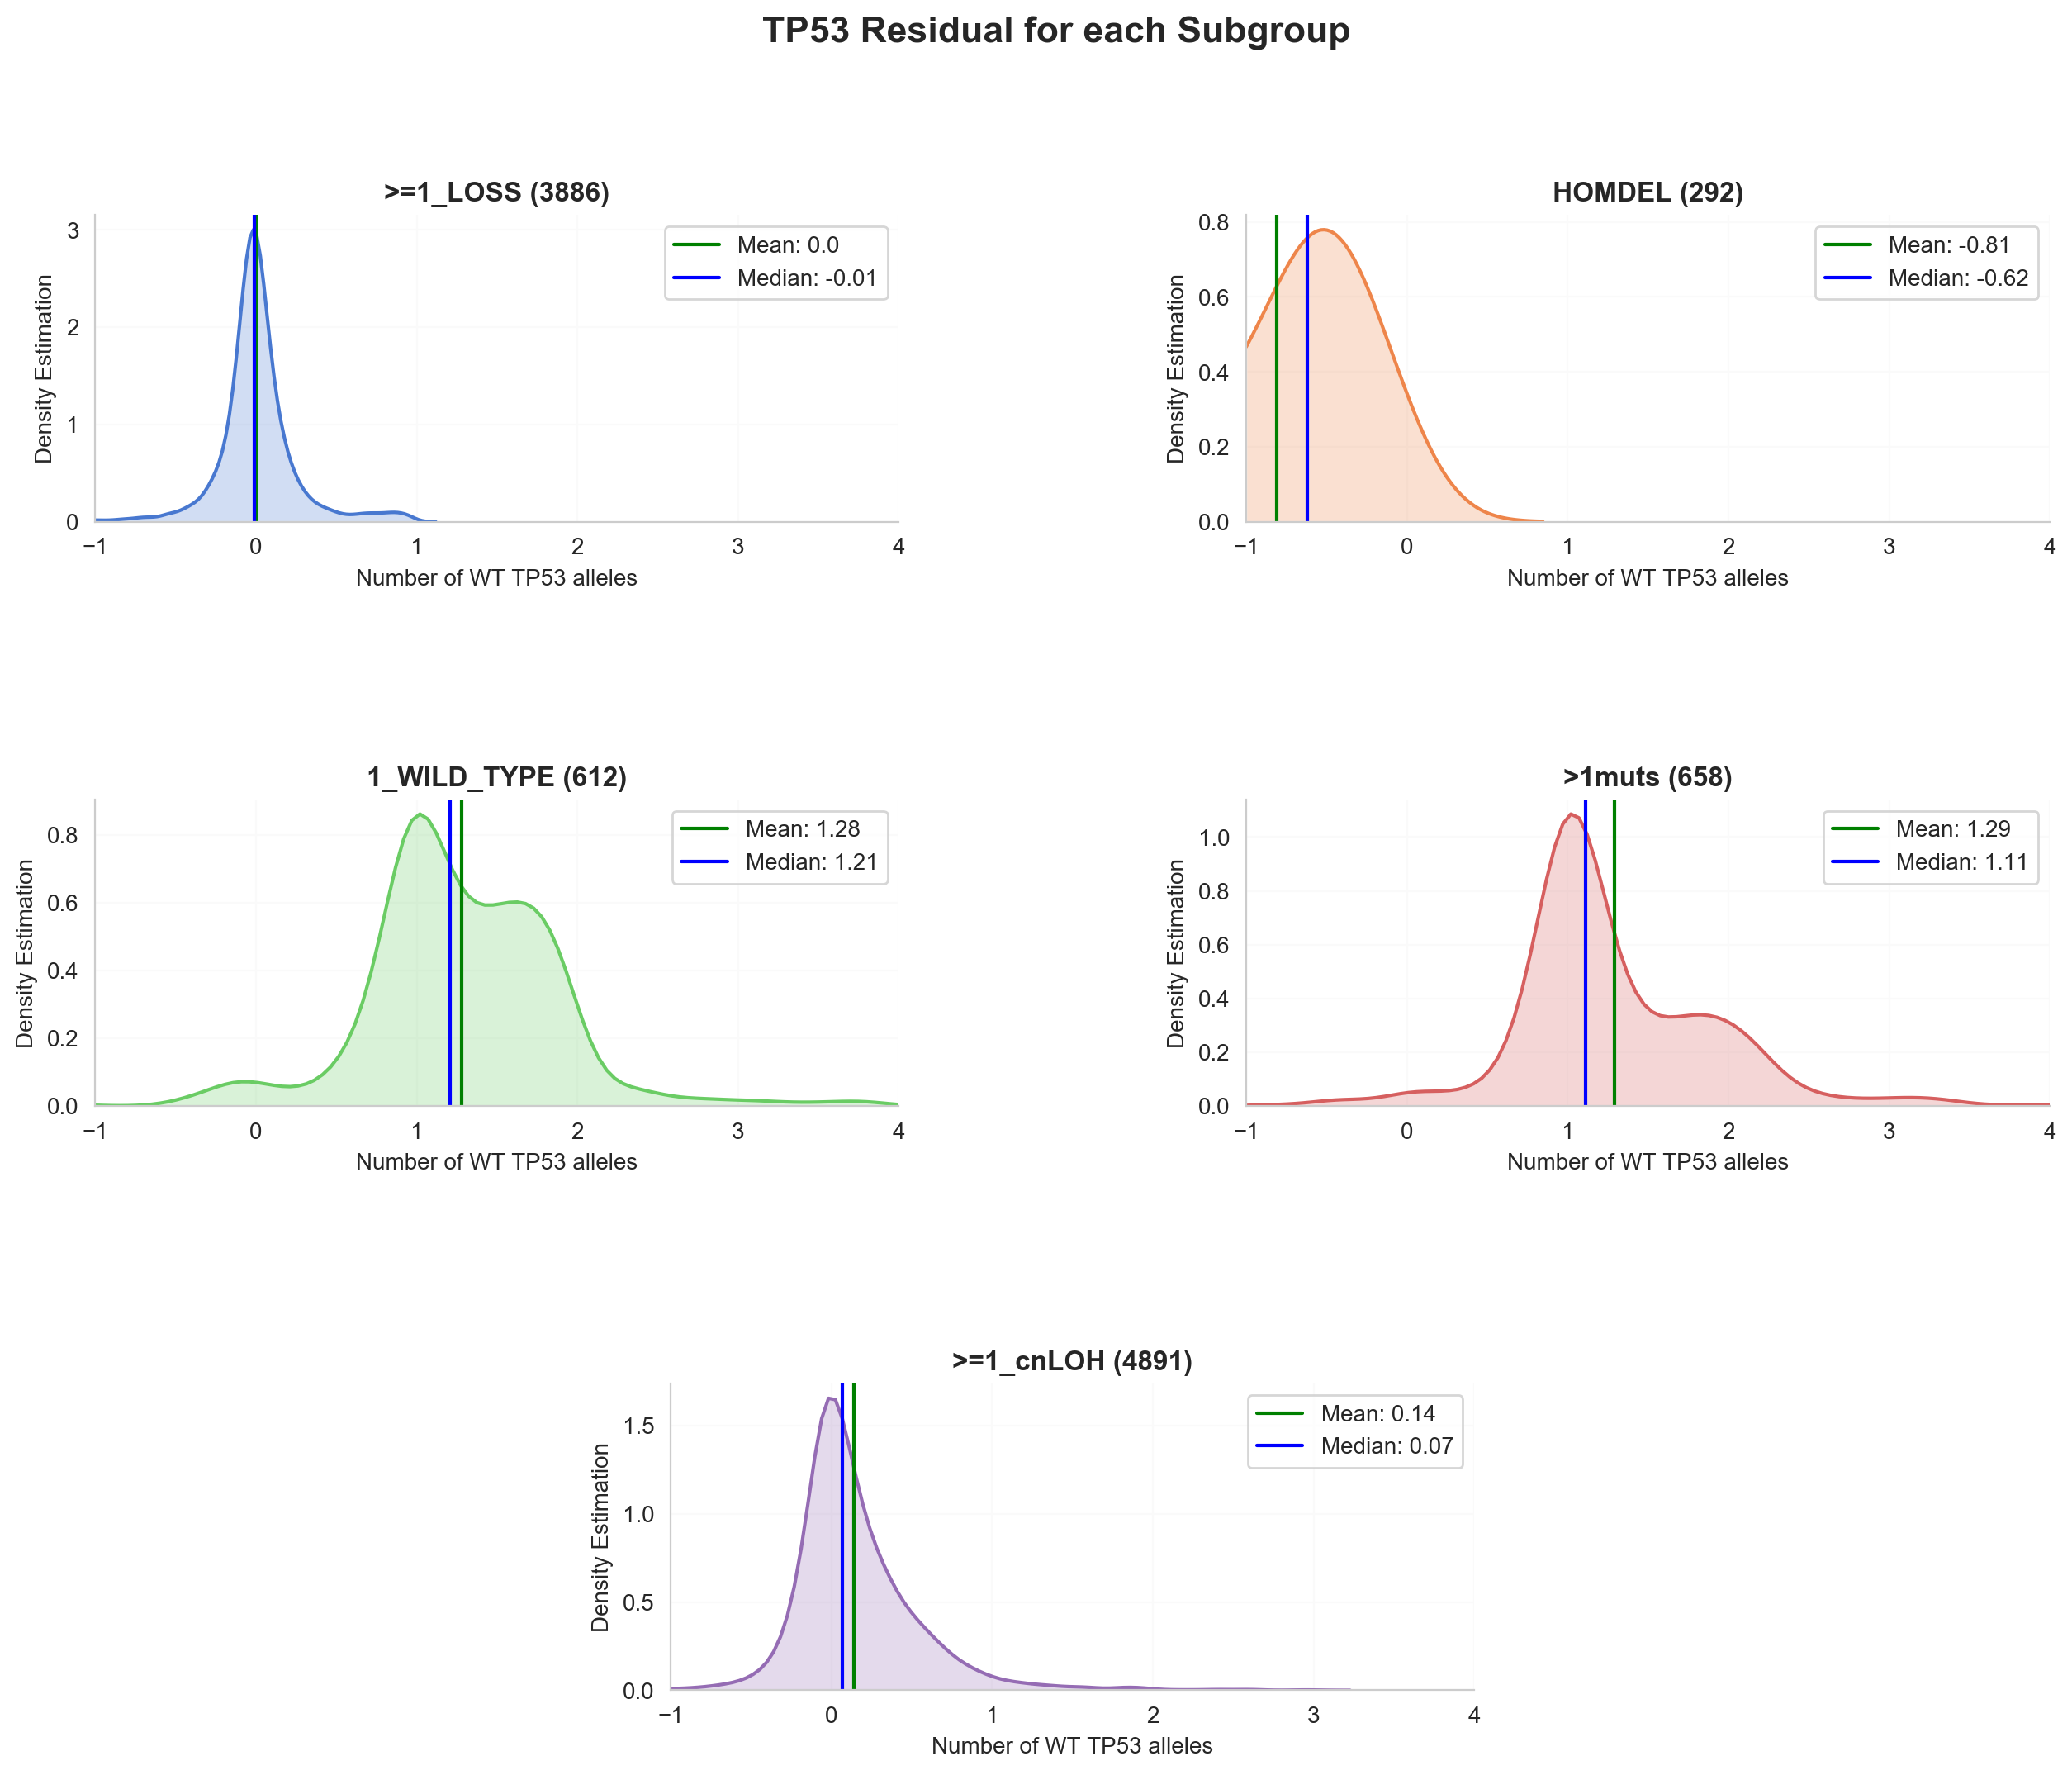

In [133]:
# For all Samples 
get_densities(master_cutoff_cleaned, 
              'tp53_residual', 
              fig_title='TP53 Residual for each Subgroup', 
              xlabel='Number of WT TP53 alleles', 
              ylabel='Density Estimation',  
              number=5,
              met_prim= None, 
              clip = (-1,4.0),
              x_lim =[-1,4])

We see that the number of samples with tp53_residuals = 0 has decreased, which is a good sign. But we want to delete these samples as they are not fitting with the group definition.

In [134]:
master_cutoff_cleaned_bis = master_cutoff_cleaned
master_cutoff_cleaned_bis.drop(master_cutoff_cleaned_bis[master_cutoff_cleaned_bis['tp53_group']=='1_WILD_TYPE'][master_cutoff_cleaned_bis['tp53_residual']<0.5].index, inplace=True)

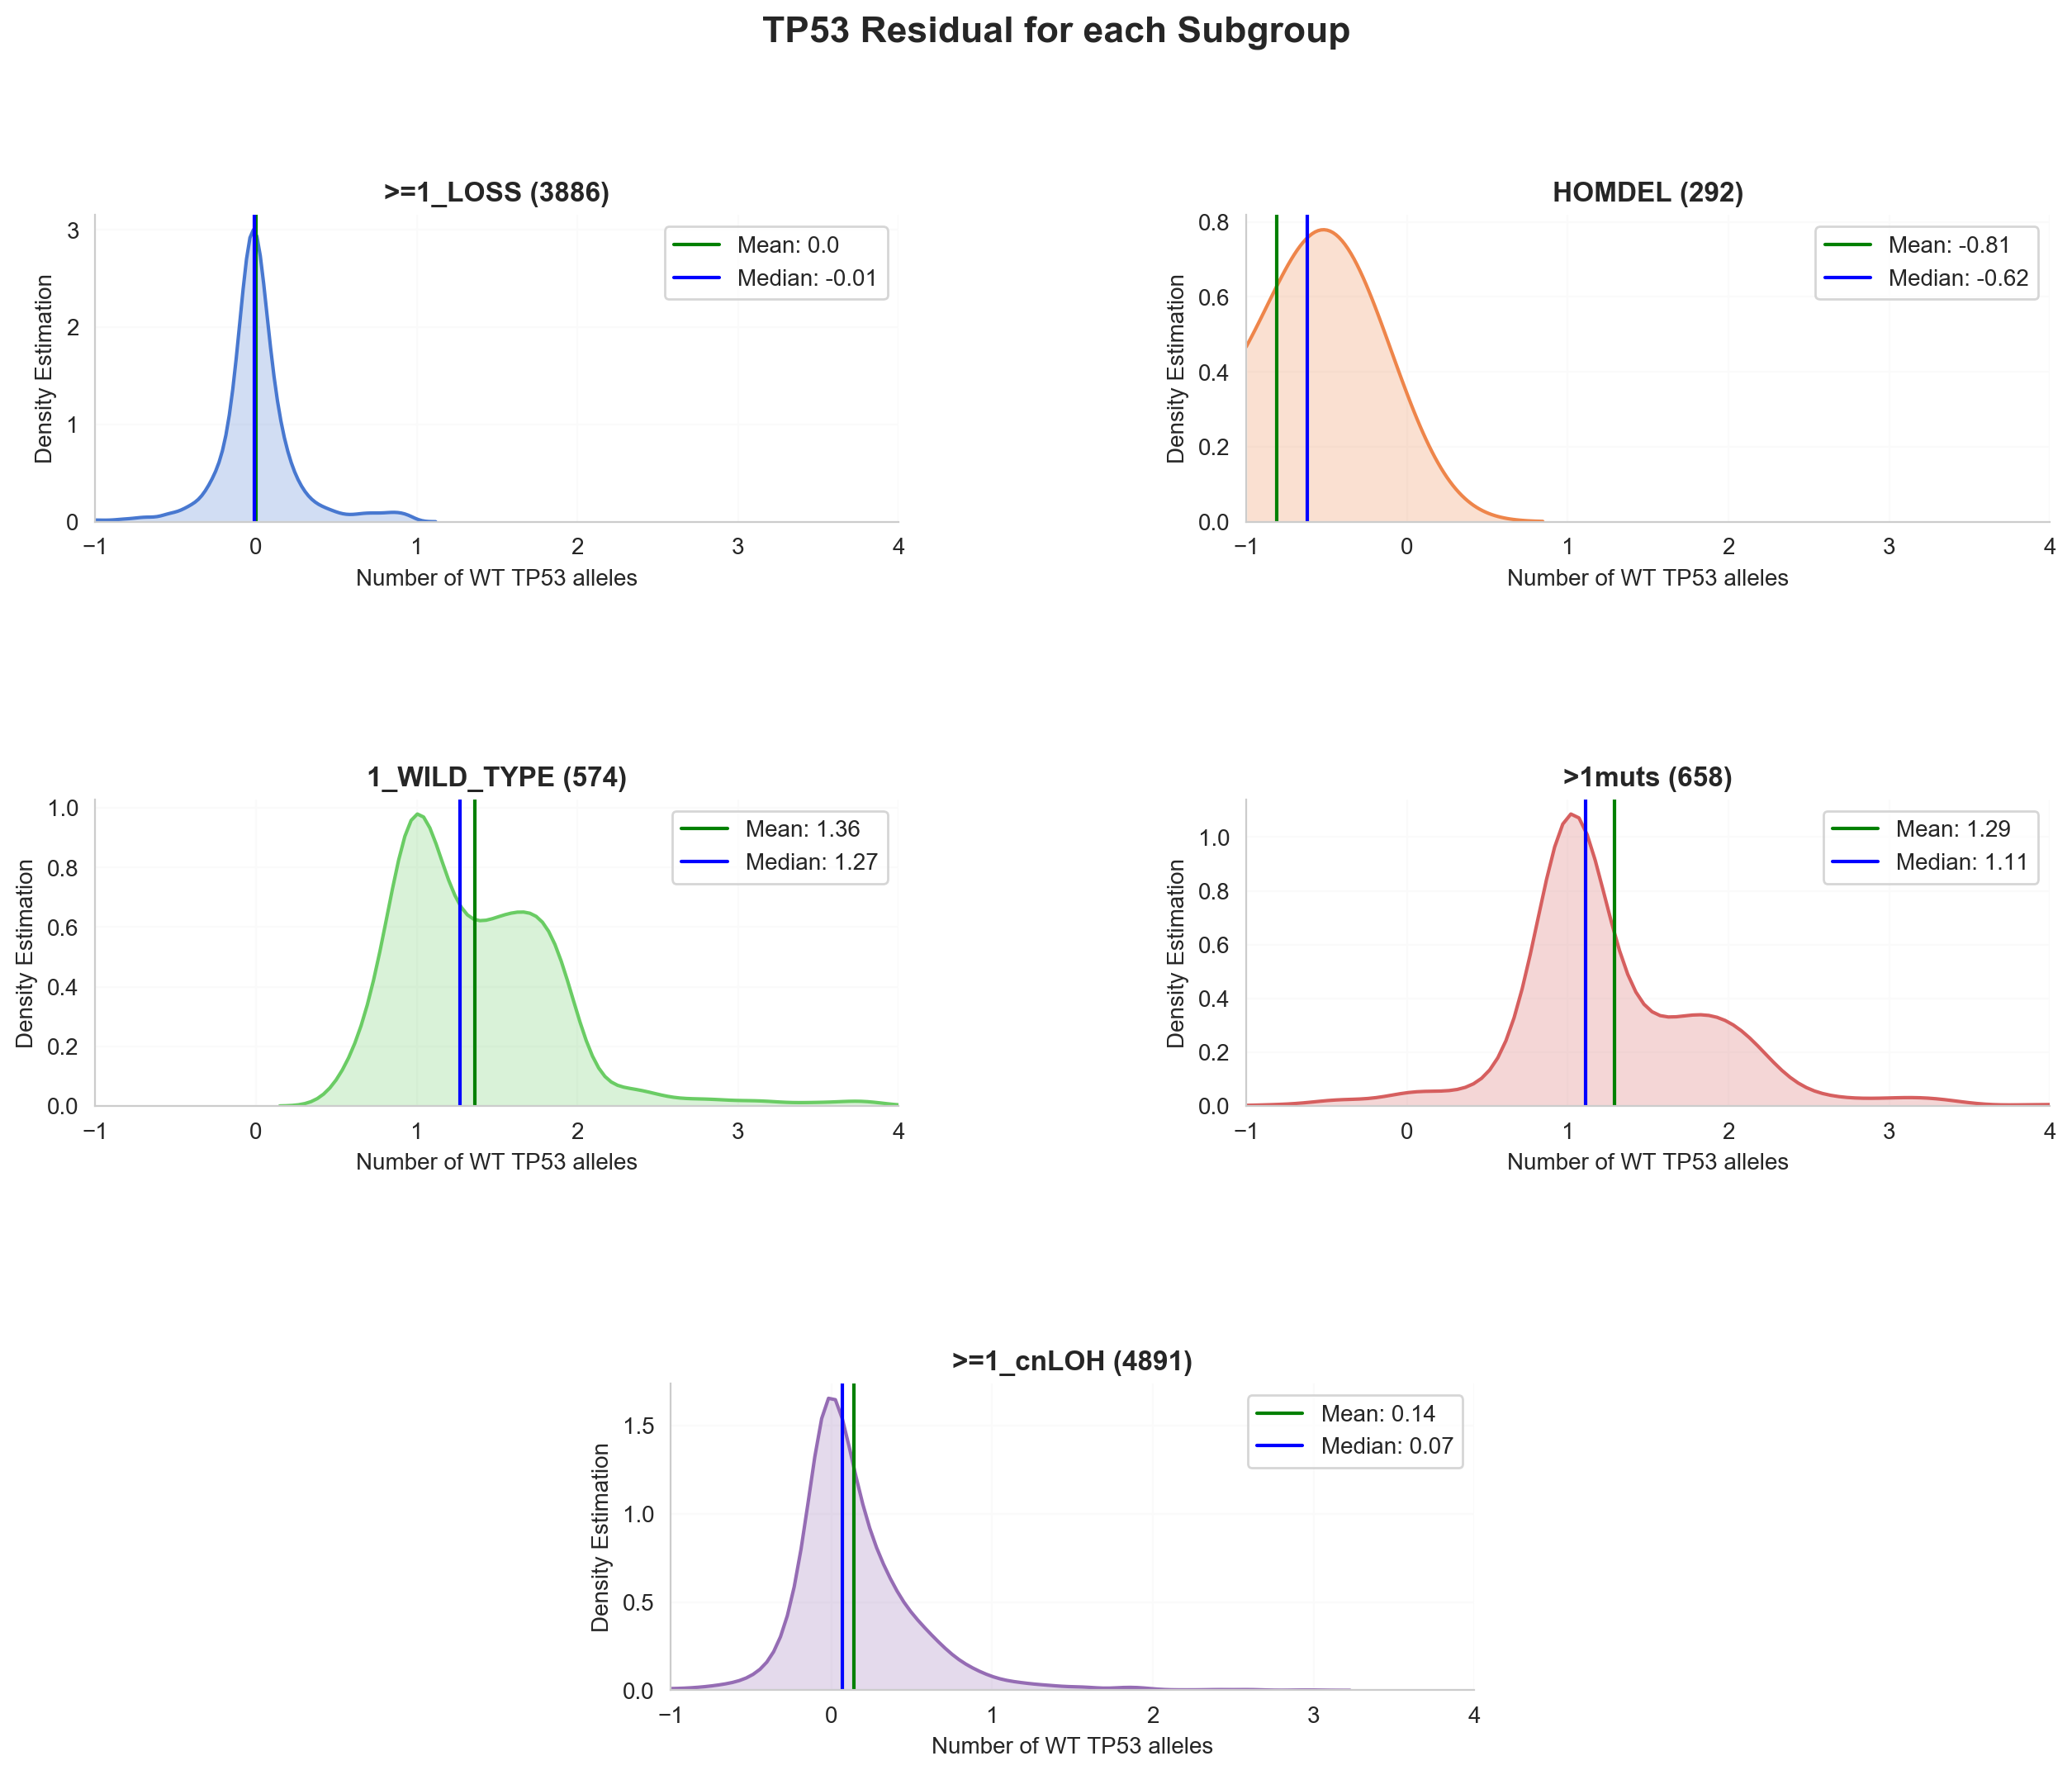

In [135]:
# For all Samples
get_densities(master_cutoff_cleaned_bis, 
              'tp53_residual', 
              fig_title='TP53 Residual for each Subgroup', 
              xlabel='Number of WT TP53 alleles', 
              ylabel='Density Estimation',  
              number=5,
              met_prim= None, 
              clip = (-1,4.0),
              x_lim =[-1,4])